In [1]:
# Cell 1: Import required libraries
import os
import yaml
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import your model and data loading components
from dataloader.dataset_wrapper import create_wrapper_from_dataframe

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Configuration and paths setup
CONFIG_PATH = "/home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/services/CSU-MS2/model/qtof_model/median_energy/checkpoints/config.yaml"
TRAIN_CSV_PATH = "/home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/data/train_deduplicated.csv"
OUTPUT_DIR = "./train_results"

# Device selection for Mac
if torch.backends.mps.is_available():
    DEVICE = 'mps'
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
elif torch.cuda.is_available():
    DEVICE = 'cuda'
    print("Using CUDA for GPU acceleration")
else:
    DEVICE = 'cpu'
    print("Using CPU")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Validation data path: {TRAIN_CSV_PATH}")

Using CUDA for GPU acceleration
Using device: cuda
Validation data path: /home/i_golov/csmp_search_engine_for_specmol/CSMP_thesis_project/data/train_deduplicated.csv


In [3]:
# Cell 3: Load configuration
print("Loading configuration...")
config = yaml.load(open(CONFIG_PATH, "r"), Loader=yaml.FullLoader)

print("Configuration loaded:")
print(f"- Batch size: {config.get('batch_size', 'Not specified')}")
print(f"- Model config keys: {list(config.get('model', {}).keys())}")
print(f"- Loss config: {config.get('loss', {})}")

Loading configuration...
Configuration loaded:
- Batch size: 64
- Model config keys: []
- Loss config: {'temperature': 0.1, 'use_cosine_similarity': True, 'alpha_weight': 0.75}


In [4]:
# Cell 4: Load and explore validation data
print("Loading train data...")
df_train = pd.read_csv(TRAIN_CSV_PATH)

print(f"Validation dataset shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"Sample data:")
df_train.head()

Loading train data...
Validation dataset shape: (798444, 10)
Columns: ['peaks_json', 'ion_source', 'compound_source', 'instrument', 'adduct', 'precursor_mz', 'smiles', 'inchikey', 'ion_mode', 'molecular_formula']
Sample data:


,peaks_json,ion_source,compound_source,instrument,adduct,precursor_mz,smiles,inchikey,ion_mode,molecular_formula
0,"[[42.014248, 0.10199999999999998], [42.26601, ...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
1,"[[49.01717, 0.155], [49.020023, 0.253], [67.05...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
2,"[[49.017338, 0.242], [49.020237, 0.181], [67.0...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
3,"[[49.01701, 0.144], [49.019947, 0.244], [139.0...",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3
4,"[[49.017166, 0.155], [49.020008, 0.253], [139....",ESI,Crude,Orbitrap,[M+H]+,377.186,CC12CCC(C(=O)N(CNc3cc4c(cc3)c3ccccc3o4)C1=O)C2...,RNKMIWQDRWSWCD-UHFFFAOYSA-N,Positive,C23H24N2O3


In [5]:
df_train_sample = df_train.sample(n=1000,random_state=42).reset_index(drop=True)

In [6]:
# Cell 6: Prepare validation data loader
print("Preparing data loaders")

# Create data wrapper from DataFrame
wrapper, processed_df = create_wrapper_from_dataframe(
    df=df_train_sample,
    batch_size=64,  
    num_workers=8,
    valid_size=0.2,  
    use_ddp=False,
    output_dir="./train_features",
)

# Get the data loader
train_loader, val_loader = wrapper.get_data_loaders()

print(f"Successfully processed {len(processed_df)} samples")
print(f"Number of batches: {len(val_loader)}")

Preparing data loaders
Convert DataFrame to compatible files
Processed 1000 valid spectra out of 1000 total entries.
Create data wrapper
calculating molecular graphs


100%|██████████| 800/800 [00:01<00:00, 638.18it/s]


Calculated 695 molecular graph-mass spectrometry pairs
calculating molecular graphs


 34%|███▎      | 67/200 [00:00<00:00, 668.11it/s]

SMILES [Cl-].O=C1C2=CC=C(O)C(=C2OC(=C1C=3C=CC=4OCCCOC4C3)C)C[NH+](C)C calculation failure


100%|██████████| 200/200 [00:00<00:00, 652.31it/s]

Calculated 165 molecular graph-mass spectrometry pairs
Successfully processed 1000 samples
Number of batches: 3


In [18]:
from model import ModelCLR

# Initialize model architecture
model = ModelCLR(**config["model_config"]).to(DEVICE)

In [19]:
# Model Architecture Overview
print("MODEL ARCHITECTURE:")
print("-" * 40)
print(f"Model Type: {type(model).__name__}")
print(f"Device: {DEVICE}")

MODEL ARCHITECTURE:
----------------------------------------
Model Type: ModelCLR
Device: cuda


In [20]:
# Submodules Analysis
print("SUBMODULES:")
print("-" * 40)
for name, module in model.named_children():
    print(f"{name:15}: {type(module).__name__}")
    if hasattr(module, '__dict__'):
        for attr_name, attr_value in module.__dict__.items():
            if not attr_name.startswith('_') and not callable(attr_value):
                if isinstance(attr_value, (int, float, str, bool)):
                    print(f"  {attr_name:12}: {attr_value}")

SUBMODULES:
----------------------------------------
Smiles_model   : SmilesModel
  training    : True
  num_layer   : 5
  emb_dim     : 300
  feat_dim    : 512
  drop_ratio  : 0.3
MS_model       : MSModel
  training    : True
smi_esa        : ESA_SMILES
  training    : True
spec_esa       : ESA_SPEC
  training    : True
smi_proj       : Linear
  training    : True
  in_features : 256
  out_features: 256
spec_proj      : Linear
  training    : True
  in_features : 256
  out_features: 256


In [21]:
# Parameter Count
print("PARAMETER ANALYSIS:")
print("-" * 40)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {total_params - trainable_params:,}")


PARAMETER ANALYSIS:
----------------------------------------
Total Parameters: 5,318,572
Trainable Parameters: 5,318,444
Non-trainable Parameters: 128


In [22]:
# Memory Usage (approximate)
print("MEMORY ANALYSIS:")
print("-" * 40)
param_size = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024 / 1024

print(f"Model Size: {model_size_mb:.2f} MB")
print(f"Parameter Memory: {param_size / 1024 / 1024:.2f} MB")
print(f"Buffer Memory: {buffer_size / 1024 / 1024:.2f} MB")


MEMORY ANALYSIS:
----------------------------------------
Model Size: 20.30 MB
Parameter Memory: 20.29 MB
Buffer Memory: 0.01 MB


In [23]:
from loss.nt_xent import NTXentLoss

# Initialize loss function
temperature = config.get('loss', {}).get('temperature', 0.1)
batch_size = config.get('batch_size', 1024)
use_cosine_similarity = config.get('loss', {}).get('use_cosine_similarity', True)
alpha_weight = config.get('loss', {}).get('alpha_weight', 1.0)

criterion = NTXentLoss(
    device=DEVICE, 
    batch_size=batch_size, 
    temperature=temperature, 
    use_cosine_similarity=use_cosine_similarity, 
    alpha_weight=alpha_weight
)

In [24]:
# Cell 15: Training Setup and Optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import time
from collections import defaultdict

print("Setting up training components...")
OUTPUT_DIR = "./model"

# Initialize optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=float(config.get('learning_rate', 5e-6)),
    weight_decay=float(config.get('weight_decay', 1e-4))
)

# Initialize scheduler
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=config.get('epochs', 4000),
    eta_min=1e-7
)

# Training configuration
epochs = config.get('epochs', 4000)
eval_every_n_epochs = config.get('eval_every_n_epochs', 5)
log_every_n_steps = config.get('log_every_n_steps', 2)

# Create checkpoint directory
checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Training for {epochs} epochs")
print(f"Optimizer: AdamW with lr={config.get('learning_rate', 5e-6)}")
print(f"Scheduler: CosineAnnealingLR")
print(f"Checkpoint directory: {checkpoint_dir}")

Setting up training components...
Training for 100 epochs
Optimizer: AdamW with lr=5e-06
Scheduler: CosineAnnealingLR
Checkpoint directory: ./model/checkpoints


In [25]:
# Cell 16: Training and Evaluation Functions
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    batch_losses = []
    
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")
    
    for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(progress_bar):
        # Move data to device
        graphs = graphs.to(device)
        mzs = mzs.to(device)
        intensities = intensities.to(device)
        num_peaks = num_peaks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
        loss = criterion(mol_features, spec_features)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track loss
        batch_loss = loss.item()
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{batch_loss:.4f}',
            'Avg Loss': f'{total_loss/num_batches:.4f}'
        })
        
        # Log every n steps
        if batch_idx % log_every_n_steps == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {batch_loss:.4f}")
    
    avg_loss = total_loss / num_batches
    return avg_loss, batch_losses

In [26]:
def compute_retrieval_metrics(molecular_features, spectral_features):
    from sklearn.metrics import pairwise_distances

    # Compute cosine distance matrix
    distance_matrix = pairwise_distances(molecular_features, spectral_features, metric='cosine')
    
    # For each molecular feature, find the rank of the correct spectral feature
    ranks = []
    for i in range(distance_matrix.shape[0]):
        sorted_indices = np.argsort(distance_matrix[i])
        rank = np.where(sorted_indices == i)[0][0] + 1  # +1 for 1-based rank
        ranks.append(rank)
    
    ranks = np.array(ranks)
    
    # Compute top-k accuracies
    top_1_accuracy = np.mean(ranks <= 1)
    top_5_accuracy = np.mean(ranks <= 5)
    top_10_accuracy = np.mean(ranks <= 10)
    
    return {
        'top_1_accuracy': top_1_accuracy,
        'top_5_accuracy': top_5_accuracy,
        'top_10_accuracy': top_10_accuracy
    }


def evaluate_model(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    molecular_features_list = []
    spectral_features_list = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Evaluating Epoch {epoch}")
        
        for batch_idx, (graphs, mzs, intensities, num_peaks) in enumerate(progress_bar):
            # Move data to device
            graphs = graphs.to(device)
            mzs = mzs.to(device)
            intensities = intensities.to(device)
            num_peaks = num_peaks.to(device)
            
            # Forward pass
            mol_features, spec_features = model(graphs, mzs, intensities, num_peaks)
            loss = criterion(mol_features, spec_features)
            
            total_loss += loss.item()
            num_batches += 1
            
            # Store features for retrieval metrics
            molecular_features_list.append(mol_features.cpu().numpy())
            spectral_features_list.append(spec_features.cpu().numpy())
            
            progress_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    
    # Compute retrieval metrics
    all_mol_features = np.vstack(molecular_features_list)
    all_spec_features = np.vstack(spectral_features_list)
    
    # Compute cosine similarities
    cosine_similarities = np.sum(all_mol_features * all_spec_features, axis=1)
    mean_similarity = np.mean(cosine_similarities)
    
    # Compute retrieval metrics
    retrieval_metrics = compute_retrieval_metrics(all_mol_features, all_spec_features)
    
    return avg_loss, mean_similarity, retrieval_metrics

In [27]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, val_loss, val_metrics, checkpoint_dir):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'config': config
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    
    # Save best model
    best_checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
    if not os.path.exists(best_checkpoint_path):
        torch.save(checkpoint, best_checkpoint_path)
        print(f"Best model saved: {best_checkpoint_path}")
    else:
        best_checkpoint = torch.load(best_checkpoint_path)
        if val_loss < best_checkpoint['val_loss']:
            torch.save(checkpoint, best_checkpoint_path)
            print(f"New best model saved: {best_checkpoint_path}")

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


In [28]:
# Cell 17: Training Loop
# Training history for plotting
train_history = {
    'epochs': [],
    'train_losses': [],
    'val_losses': [],
    'val_similarities': [],
    'val_top1_acc': [],
    'val_top5_acc': [],
    'val_top10_acc': [],
    'learning_rates': []
}

best_val_loss = float('inf')
start_time = time.time()

print("Starting training...")
print("=" * 60)

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    
    # Training phase
    train_loss, batch_losses = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE, epoch
    )
    
    # Validation phase (every n epochs)
    if epoch % eval_every_n_epochs == 0:
        val_loss, val_similarity, val_metrics = evaluate_model(
            model, val_loader, criterion, DEVICE, epoch
        )
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Log results
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        print(f"\nEpoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f}")
        print(f"Val Similarity: {val_similarity:.4f}")
        print(f"Top-1 Accuracy: {val_metrics['top_1_accuracy']:.4f}")
        print(f"Top-5 Accuracy: {val_metrics['top_5_accuracy']:.4f}")
        print(f"Top-10 Accuracy: {val_metrics['top_10_accuracy']:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print(f"Epoch Time: {epoch_time:.2f}s, Total Time: {total_time:.2f}s")
        print("-" * 60)
        
        # Store history - convert numpy types to Python native types
        train_history['epochs'].append(int(epoch))
        train_history['train_losses'].append(float(train_loss))
        train_history['val_losses'].append(float(val_loss))
        train_history['val_similarities'].append(float(val_similarity))
        train_history['val_top1_acc'].append(float(val_metrics['top_1_accuracy']))
        train_history['val_top5_acc'].append(float(val_metrics['top_5_accuracy']))
        train_history['val_top10_acc'].append(float(val_metrics['top_10_accuracy']))
        train_history['learning_rates'].append(float(current_lr))
        
        # Save checkpoint
        save_checkpoint(
            model, optimizer, scheduler, epoch, 
            train_loss, val_loss, val_metrics, checkpoint_dir
        )
        
        # Save training history with error handling
        history_path = os.path.join(OUTPUT_DIR, 'training_history.json')
        try:
            with open(history_path, 'w') as f:
                json.dump(train_history, f, indent=2)
        except TypeError as e:
            print(f"Warning: Could not save training history to JSON: {e}")
            # Alternative: save as pickle
            import pickle
            pickle_path = os.path.join(OUTPUT_DIR, 'training_history.pkl')
            with open(pickle_path, 'wb') as f:
                pickle.dump(train_history, f)
            print(f"Training history saved as pickle: {pickle_path}")
    
    else:
        # Just update learning rate and log basic info
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, LR: {current_lr:.2e}, Time: {epoch_time:.2f}s")

print("\nTraining completed!")
print(f"Total training time: {(time.time() - start_time)/3600:.2f} hours")

Starting training...


Training Epoch 1:  30%|███       | 3/10 [00:00<00:01,  5.30it/s, Loss=4.2076, Avg Loss=4.2049]

Epoch 1, Batch 0, Loss: 4.2019
Epoch 1, Batch 2, Loss: 4.2076


Training Epoch 1:  50%|█████     | 5/10 [00:00<00:00,  7.55it/s, Loss=4.2004, Avg Loss=4.2048]

Epoch 1, Batch 4, Loss: 4.1979


Training Epoch 1:  70%|███████   | 7/10 [00:01<00:00,  6.56it/s, Loss=4.1802, Avg Loss=4.2013]

Epoch 1, Batch 6, Loss: 4.1802


Training Epoch 1: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, Loss=4.1914, Avg Loss=4.1988]


Epoch 1, Batch 8, Loss: 4.2060
Epoch 1/100 - Train Loss: 4.198793, LR: 5.00e-06, Time: 1.68s


Training Epoch 2:  30%|███       | 3/10 [00:00<00:01,  5.64it/s, Loss=4.1741, Avg Loss=4.1787]

Epoch 2, Batch 0, Loss: 4.1834
Epoch 2, Batch 2, Loss: 4.1741


Training Epoch 2:  50%|█████     | 5/10 [00:00<00:00,  7.89it/s, Loss=4.1999, Avg Loss=4.1852]

Epoch 2, Batch 4, Loss: 4.1785


Training Epoch 2:  70%|███████   | 7/10 [00:01<00:00,  6.83it/s, Loss=4.1854, Avg Loss=4.1852]

Epoch 2, Batch 6, Loss: 4.1854


Training Epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, Loss=4.1824, Avg Loss=4.1823]


Epoch 2, Batch 8, Loss: 4.1649
Epoch 2/100 - Train Loss: 4.182287, LR: 5.00e-06, Time: 1.65s


Training Epoch 3:  30%|███       | 3/10 [00:00<00:01,  5.64it/s, Loss=4.1770, Avg Loss=4.1754]

Epoch 3, Batch 0, Loss: 4.1755
Epoch 3, Batch 2, Loss: 4.1770


Training Epoch 3:  50%|█████     | 5/10 [00:00<00:00,  7.87it/s, Loss=4.1782, Avg Loss=4.1751]

Epoch 3, Batch 4, Loss: 4.1775


Training Epoch 3:  70%|███████   | 7/10 [00:01<00:00,  6.82it/s, Loss=4.1745, Avg Loss=4.1750]

Epoch 3, Batch 6, Loss: 4.1745


Training Epoch 3: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s, Loss=4.1508, Avg Loss=4.1724]


Epoch 3, Batch 8, Loss: 4.1704
Epoch 3/100 - Train Loss: 4.172352, LR: 4.99e-06, Time: 1.67s


Training Epoch 4:  30%|███       | 3/10 [00:00<00:01,  5.66it/s, Loss=4.1765, Avg Loss=4.1764]

Epoch 4, Batch 0, Loss: 4.1809
Epoch 4, Batch 2, Loss: 4.1765


Training Epoch 4:  50%|█████     | 5/10 [00:00<00:00,  8.04it/s, Loss=4.1525, Avg Loss=4.1692]

Epoch 4, Batch 4, Loss: 4.1525


Training Epoch 4:  90%|█████████ | 9/10 [00:01<00:00,  6.52it/s, Loss=4.1645, Avg Loss=4.1707]

Epoch 4, Batch 6, Loss: 4.1662
Epoch 4, Batch 8, Loss: 4.1645


Training Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, Loss=4.1752, Avg Loss=4.1712]


Epoch 4/100 - Train Loss: 4.171168, LR: 4.98e-06, Time: 1.65s


Training Epoch 5:  30%|███       | 3/10 [00:00<00:01,  5.73it/s, Loss=4.1625, Avg Loss=4.1646]

Epoch 5, Batch 0, Loss: 4.1730
Epoch 5, Batch 2, Loss: 4.1625


Training Epoch 5:  50%|█████     | 5/10 [00:00<00:00,  8.06it/s, Loss=4.1619, Avg Loss=4.1673]

Epoch 5, Batch 4, Loss: 4.1619


Training Epoch 5:  80%|████████  | 8/10 [00:01<00:00,  5.78it/s, Loss=4.1708, Avg Loss=4.1709]

Epoch 5, Batch 6, Loss: 4.1671


Training Epoch 5: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, Loss=4.1631, Avg Loss=4.1685]


Epoch 5, Batch 8, Loss: 4.1556


Evaluating Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  5.79it/s, Val Loss=3.6148]



Epoch 5/100
Train Loss: 4.168545
Val Loss: 3.977808
Val Similarity: -0.1276
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0364
Top-10 Accuracy: 0.0545
Learning Rate: 4.97e-06
Epoch Time: 2.20s, Total Time: 8.86s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_5.pth


Training Epoch 6:  20%|██        | 2/10 [00:00<00:01,  4.06it/s, Loss=4.1521, Avg Loss=4.1591]

Epoch 6, Batch 0, Loss: 4.1693
Epoch 6, Batch 2, Loss: 4.1521


Training Epoch 6:  40%|████      | 4/10 [00:00<00:00,  6.98it/s, Loss=4.1626, Avg Loss=4.1607]

Epoch 6, Batch 4, Loss: 4.1626


Training Epoch 6:  70%|███████   | 7/10 [00:01<00:00,  5.21it/s, Loss=4.1500, Avg Loss=4.1625]

Epoch 6, Batch 6, Loss: 4.1672


Training Epoch 6: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s, Loss=4.1553, Avg Loss=4.1618]


Epoch 6, Batch 8, Loss: 4.1500
Epoch 6/100 - Train Loss: 4.161757, LR: 4.96e-06, Time: 1.72s


Training Epoch 7:  30%|███       | 3/10 [00:00<00:01,  5.71it/s, Loss=4.1447, Avg Loss=4.1583]

Epoch 7, Batch 0, Loss: 4.1736
Epoch 7, Batch 2, Loss: 4.1447


Training Epoch 7:  50%|█████     | 5/10 [00:00<00:00,  8.08it/s, Loss=4.1310, Avg Loss=4.1541]

Epoch 7, Batch 4, Loss: 4.1310


Training Epoch 7:  90%|█████████ | 9/10 [00:01<00:00,  6.63it/s, Loss=4.1381, Avg Loss=4.1550]

Epoch 7, Batch 6, Loss: 4.1494
Epoch 7, Batch 8, Loss: 4.1381


Training Epoch 7: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Loss=4.1486, Avg Loss=4.1543]


Epoch 7/100 - Train Loss: 4.154339, LR: 4.94e-06, Time: 1.64s


Training Epoch 8:  30%|███       | 3/10 [00:00<00:01,  5.68it/s, Loss=4.1487, Avg Loss=4.1495]

Epoch 8, Batch 0, Loss: 4.1609
Epoch 8, Batch 2, Loss: 4.1487


Training Epoch 8:  50%|█████     | 5/10 [00:00<00:00,  7.99it/s, Loss=4.1569, Avg Loss=4.1531]

Epoch 8, Batch 4, Loss: 4.1569


Training Epoch 8:  70%|███████   | 7/10 [00:01<00:00,  5.10it/s, Loss=4.1373, Avg Loss=4.1532]

Epoch 8, Batch 6, Loss: 4.1575


Training Epoch 8: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s, Loss=4.1488, Avg Loss=4.1527]


Epoch 8, Batch 8, Loss: 4.1527
Epoch 8/100 - Train Loss: 4.152687, LR: 4.92e-06, Time: 1.66s


Training Epoch 9:  30%|███       | 3/10 [00:00<00:01,  5.69it/s, Loss=4.1518, Avg Loss=4.1478]

Epoch 9, Batch 0, Loss: 4.1613
Epoch 9, Batch 2, Loss: 4.1518


Training Epoch 9:  60%|██████    | 6/10 [00:01<00:00,  5.38it/s, Loss=4.1733, Avg Loss=4.1522]

Epoch 9, Batch 4, Loss: 4.1406


Training Epoch 9:  90%|█████████ | 9/10 [00:01<00:00,  7.60it/s, Loss=4.1219, Avg Loss=4.1478]

Epoch 9, Batch 6, Loss: 4.1390
Epoch 9, Batch 8, Loss: 4.1219


Training Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s, Loss=4.1379, Avg Loss=4.1468]


Epoch 9/100 - Train Loss: 4.146838, LR: 4.90e-06, Time: 1.68s


Training Epoch 10:  30%|███       | 3/10 [00:00<00:01,  5.99it/s, Loss=4.1419, Avg Loss=4.1389]

Epoch 10, Batch 0, Loss: 4.1474
Epoch 10, Batch 2, Loss: 4.1419


Training Epoch 10:  60%|██████    | 6/10 [00:01<00:00,  5.61it/s, Loss=4.1522, Avg Loss=4.1442]

Epoch 10, Batch 4, Loss: 4.1465


Training Epoch 10:  90%|█████████ | 9/10 [00:01<00:00,  7.71it/s, Loss=4.1452, Avg Loss=4.1453]

Epoch 10, Batch 6, Loss: 4.1554
Epoch 10, Batch 8, Loss: 4.1452


Evaluating Epoch 10: 100%|██████████| 3/3 [00:00<00:00,  5.79it/s, Val Loss=3.5920]



Epoch 10/100
Train Loss: 4.144004
Val Loss: 3.964731
Val Similarity: 0.3172
Top-1 Accuracy: 0.0182
Top-5 Accuracy: 0.0545
Top-10 Accuracy: 0.0727
Learning Rate: 4.88e-06
Epoch Time: 2.17s, Total Time: 18.13s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_10.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 11:  30%|███       | 3/10 [00:00<00:01,  5.87it/s, Loss=4.1293, Avg Loss=4.1399]

Epoch 11, Batch 0, Loss: 4.1587
Epoch 11, Batch 2, Loss: 4.1293


Training Epoch 11:  60%|██████    | 6/10 [00:01<00:00,  5.58it/s, Loss=4.1486, Avg Loss=4.1417]

Epoch 11, Batch 4, Loss: 4.1378


Training Epoch 11:  70%|███████   | 7/10 [00:01<00:00,  6.35it/s, Loss=4.1497, Avg Loss=4.1433]

Epoch 11, Batch 6, Loss: 4.1466


Training Epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s, Loss=4.1435, Avg Loss=4.1416]


Epoch 11, Batch 8, Loss: 4.1262
Epoch 11/100 - Train Loss: 4.141619, LR: 4.86e-06, Time: 1.66s


Training Epoch 12:  10%|█         | 1/10 [00:00<00:03,  2.47it/s, Loss=4.1269, Avg Loss=4.1306]

Epoch 12, Batch 0, Loss: 4.1343


Training Epoch 12:  30%|███       | 3/10 [00:00<00:01,  4.33it/s, Loss=4.1315, Avg Loss=4.1309]

Epoch 12, Batch 2, Loss: 4.1315


Training Epoch 12:  70%|███████   | 7/10 [00:01<00:00,  6.72it/s, Loss=4.1317, Avg Loss=4.1344]

Epoch 12, Batch 4, Loss: 4.1381
Epoch 12, Batch 6, Loss: 4.1317


Training Epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s, Loss=4.1439, Avg Loss=4.1321]


Epoch 12, Batch 8, Loss: 4.1077
Epoch 12/100 - Train Loss: 4.132111, LR: 4.83e-06, Time: 1.64s


Training Epoch 13:  30%|███       | 3/10 [00:00<00:01,  5.97it/s, Loss=4.1232, Avg Loss=4.1232]

Epoch 13, Batch 0, Loss: 4.1312
Epoch 13, Batch 2, Loss: 4.1232


Training Epoch 13:  60%|██████    | 6/10 [00:01<00:00,  5.62it/s, Loss=4.1624, Avg Loss=4.1346]

Epoch 13, Batch 4, Loss: 4.1282


Training Epoch 13:  80%|████████  | 8/10 [00:01<00:00,  7.09it/s, Loss=4.1291, Avg Loss=4.1356]

Epoch 13, Batch 6, Loss: 4.1481


Training Epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s, Loss=4.1147, Avg Loss=4.1332]


Epoch 13, Batch 8, Loss: 4.1321
Epoch 13/100 - Train Loss: 4.133173, LR: 4.80e-06, Time: 1.66s


Training Epoch 14:  10%|█         | 1/10 [00:00<00:03,  2.35it/s, Loss=4.1182, Avg Loss=4.1182]

Epoch 14, Batch 0, Loss: 4.1182


Training Epoch 14:  50%|█████     | 5/10 [00:01<00:00,  5.73it/s, Loss=4.1155, Avg Loss=4.1181]

Epoch 14, Batch 2, Loss: 4.1406
Epoch 14, Batch 4, Loss: 4.1155


Training Epoch 14:  90%|█████████ | 9/10 [00:01<00:00,  8.16it/s, Loss=4.1092, Avg Loss=4.1221]

Epoch 14, Batch 6, Loss: 4.1319
Epoch 14, Batch 8, Loss: 4.1092


Training Epoch 14: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, Loss=4.1352, Avg Loss=4.1234]


Epoch 14/100 - Train Loss: 4.123428, LR: 4.77e-06, Time: 1.84s


Training Epoch 15:  20%|██        | 2/10 [00:00<00:02,  3.22it/s, Loss=4.1360, Avg Loss=4.1187]

Epoch 15, Batch 0, Loss: 4.1182
Epoch 15, Batch 2, Loss: 4.1360


Training Epoch 15:  50%|█████     | 5/10 [00:01<00:01,  4.31it/s, Loss=4.1642, Avg Loss=4.1319]

Epoch 15, Batch 4, Loss: 4.1342


Training Epoch 15:  90%|█████████ | 9/10 [00:01<00:00,  6.99it/s, Loss=4.1127, Avg Loss=4.1307]

Epoch 15, Batch 6, Loss: 4.1389
Epoch 15, Batch 8, Loss: 4.1127


Evaluating Epoch 15: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s, Val Loss=3.5755]



Epoch 15/100
Train Loss: 4.130747
Val Loss: 3.946928
Val Similarity: 0.4124
Top-1 Accuracy: 0.0242
Top-5 Accuracy: 0.0485
Top-10 Accuracy: 0.0788
Learning Rate: 4.73e-06
Epoch Time: 2.83s, Total Time: 28.25s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_15.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 16:  20%|██        | 2/10 [00:00<00:03,  2.64it/s, Loss=4.0756, Avg Loss=4.0940]

Epoch 16, Batch 0, Loss: 4.1124


Training Epoch 16:  50%|█████     | 5/10 [00:01<00:00,  6.24it/s, Loss=4.1009, Avg Loss=4.1070]

Epoch 16, Batch 2, Loss: 4.1209
Epoch 16, Batch 4, Loss: 4.1009


Training Epoch 16:  70%|███████   | 7/10 [00:01<00:00,  6.00it/s, Loss=4.1433, Avg Loss=4.1149]

Epoch 16, Batch 6, Loss: 4.1433


Training Epoch 16: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, Loss=4.1312, Avg Loss=4.1162]

Epoch 16, Batch 8, Loss: 4.1110


Epoch 16/100 - Train Loss: 4.116163, LR: 4.70e-06, Time: 2.09s


Training Epoch 17:  10%|█         | 1/10 [00:00<00:06,  1.44it/s, Loss=4.1110, Avg Loss=4.1110]

Epoch 17, Batch 0, Loss: 4.1110


Training Epoch 17:  50%|█████     | 5/10 [00:01<00:00,  6.02it/s, Loss=4.1239, Avg Loss=4.1080]

Epoch 17, Batch 2, Loss: 4.1057
Epoch 17, Batch 4, Loss: 4.1239


Training Epoch 17:  70%|███████   | 7/10 [00:01<00:00,  7.59it/s, Loss=4.1327, Avg Loss=4.1144]

Epoch 17, Batch 6, Loss: 4.1327


Training Epoch 17: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, Loss=4.1232, Avg Loss=4.1123]


Epoch 17, Batch 8, Loss: 4.0925
Epoch 17/100 - Train Loss: 4.112337, LR: 4.66e-06, Time: 2.09s


Training Epoch 18:  10%|█         | 1/10 [00:00<00:04,  2.14it/s, Loss=4.0714, Avg Loss=4.0902]

Epoch 18, Batch 0, Loss: 4.1090


Training Epoch 18:  30%|███       | 3/10 [00:00<00:01,  4.03it/s, Loss=4.1108, Avg Loss=4.0971]

Epoch 18, Batch 2, Loss: 4.1108


Training Epoch 18:  70%|███████   | 7/10 [00:01<00:00,  6.54it/s, Loss=4.1177, Avg Loss=4.1034]

Epoch 18, Batch 4, Loss: 4.0708
Epoch 18, Batch 6, Loss: 4.1177


Training Epoch 18: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, Loss=4.1070, Avg Loss=4.1002]


Epoch 18, Batch 8, Loss: 4.0774
Epoch 18/100 - Train Loss: 4.100247, LR: 4.62e-06, Time: 1.72s


Training Epoch 19:  20%|██        | 2/10 [00:00<00:03,  2.62it/s, Loss=4.0408, Avg Loss=4.0666]

Epoch 19, Batch 0, Loss: 4.0925


Training Epoch 19:  40%|████      | 4/10 [00:01<00:01,  5.13it/s, Loss=4.0879, Avg Loss=4.0826]

Epoch 19, Batch 2, Loss: 4.1067
Epoch 19, Batch 4, Loss: 4.0879


Training Epoch 19:  70%|███████   | 7/10 [00:01<00:00,  7.51it/s, Loss=4.1093, Avg Loss=4.0914]

Epoch 19, Batch 6, Loss: 4.1093


Training Epoch 19: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s, Loss=4.0938, Avg Loss=4.0925]


Epoch 19, Batch 8, Loss: 4.0819
Epoch 19/100 - Train Loss: 4.092536, LR: 4.58e-06, Time: 2.02s


Training Epoch 20:  10%|█         | 1/10 [00:00<00:04,  2.12it/s, Loss=4.0216, Avg Loss=4.0480]

Epoch 20, Batch 0, Loss: 4.0745


Training Epoch 20:  30%|███       | 3/10 [00:00<00:01,  3.99it/s, Loss=4.0834, Avg Loss=4.0598]

Epoch 20, Batch 2, Loss: 4.0834


Training Epoch 20:  70%|███████   | 7/10 [00:01<00:00,  6.54it/s, Loss=4.1339, Avg Loss=4.0762]

Epoch 20, Batch 4, Loss: 4.0538
Epoch 20, Batch 6, Loss: 4.1339


Training Epoch 20: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s, Loss=4.0730, Avg Loss=4.0765]


Epoch 20, Batch 8, Loss: 4.0624


Evaluating Epoch 20: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, Val Loss=3.5526]



Epoch 20/100
Train Loss: 4.076453
Val Loss: 3.910990
Val Similarity: 0.4480
Top-1 Accuracy: 0.0182
Top-5 Accuracy: 0.0848
Top-10 Accuracy: 0.1273
Learning Rate: 4.53e-06
Epoch Time: 2.64s, Total Time: 39.35s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_20.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 21:  20%|██        | 2/10 [00:00<00:03,  2.58it/s, Loss=4.0144, Avg Loss=4.0352]

Epoch 21, Batch 0, Loss: 4.0560


Training Epoch 21:  50%|█████     | 5/10 [00:01<00:00,  6.36it/s, Loss=4.0553, Avg Loss=4.0468]

Epoch 21, Batch 2, Loss: 4.0488
Epoch 21, Batch 4, Loss: 4.0553


Training Epoch 21:  70%|███████   | 7/10 [00:01<00:00,  7.95it/s, Loss=4.1141, Avg Loss=4.0611]

Epoch 21, Batch 6, Loss: 4.1141


Training Epoch 21: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, Loss=4.0503, Avg Loss=4.0548]


Epoch 21, Batch 8, Loss: 4.0086
Epoch 21/100 - Train Loss: 4.054813, LR: 4.49e-06, Time: 2.04s


Training Epoch 22:  10%|█         | 1/10 [00:00<00:04,  2.12it/s, Loss=3.9354, Avg Loss=3.9829]

Epoch 22, Batch 0, Loss: 4.0304


Training Epoch 22:  30%|███       | 3/10 [00:00<00:01,  4.03it/s, Loss=4.0414, Avg Loss=4.0024]

Epoch 22, Batch 2, Loss: 4.0414


Training Epoch 22:  70%|███████   | 7/10 [00:01<00:00,  6.54it/s, Loss=4.1101, Avg Loss=4.0325]

Epoch 22, Batch 4, Loss: 3.9888
Epoch 22, Batch 6, Loss: 4.1101


Training Epoch 22:  90%|█████████ | 9/10 [00:01<00:00,  7.68it/s, Loss=3.9969, Avg Loss=4.0297]

Epoch 22, Batch 8, Loss: 3.9969


Training Epoch 22: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s, Loss=4.0306, Avg Loss=4.0298]


Epoch 22/100 - Train Loss: 4.029799, LR: 4.44e-06, Time: 1.93s


Training Epoch 23:  30%|███       | 3/10 [00:00<00:01,  4.62it/s, Loss=4.0394, Avg Loss=4.0004]

Epoch 23, Batch 0, Loss: 4.0330
Epoch 23, Batch 2, Loss: 4.0394


Training Epoch 23:  50%|█████     | 5/10 [00:00<00:00,  6.86it/s, Loss=4.0661, Avg Loss=4.0119]

Epoch 23, Batch 4, Loss: 3.9799


Training Epoch 23:  70%|███████   | 7/10 [00:01<00:00,  6.33it/s, Loss=4.0356, Avg Loss=4.0153]

Epoch 23, Batch 6, Loss: 4.0356


Training Epoch 23: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s, Loss=4.0277, Avg Loss=4.0092]


Epoch 23, Batch 8, Loss: 3.9865
Epoch 23/100 - Train Loss: 4.009229, LR: 4.39e-06, Time: 1.82s


Training Epoch 24:  10%|█         | 1/10 [00:00<00:04,  2.11it/s, Loss=3.9692, Avg Loss=3.9692]

Epoch 24, Batch 0, Loss: 3.9692


Training Epoch 24:  50%|█████     | 5/10 [00:01<00:00,  5.63it/s, Loss=3.9983, Avg Loss=3.9659]

Epoch 24, Batch 2, Loss: 4.0017
Epoch 24, Batch 4, Loss: 3.9983


Training Epoch 24:  80%|████████  | 8/10 [00:01<00:00,  7.62it/s, Loss=4.0253, Avg Loss=3.9969]

Epoch 24, Batch 6, Loss: 4.0785


Training Epoch 24:  90%|█████████ | 9/10 [00:01<00:00,  6.26it/s, Loss=3.9828, Avg Loss=3.9954]

Epoch 24, Batch 8, Loss: 3.9828


Training Epoch 24: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s, Loss=3.9927, Avg Loss=3.9951]


Epoch 24/100 - Train Loss: 3.995092, LR: 4.34e-06, Time: 2.06s


Training Epoch 25:  30%|███       | 3/10 [00:00<00:01,  5.25it/s, Loss=3.9626, Avg Loss=3.9418]

Epoch 25, Batch 0, Loss: 3.9759
Epoch 25, Batch 2, Loss: 3.9626


Training Epoch 25:  50%|█████     | 5/10 [00:00<00:00,  7.66it/s, Loss=3.9163, Avg Loss=3.9390]

Epoch 25, Batch 4, Loss: 3.9163


Training Epoch 25:  80%|████████  | 8/10 [00:01<00:00,  5.91it/s, Loss=3.9682, Avg Loss=3.9724]

Epoch 25, Batch 6, Loss: 4.0271


Training Epoch 25: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s, Loss=3.9817, Avg Loss=3.9717]


Epoch 25, Batch 8, Loss: 3.9563


Evaluating Epoch 25: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s, Val Loss=3.5847]



Epoch 25/100
Train Loss: 3.971738
Val Loss: 3.897513
Val Similarity: 0.6276
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0545
Top-10 Accuracy: 0.1212
Learning Rate: 4.28e-06
Epoch Time: 2.70s, Total Time: 50.46s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_25.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 26:  30%|███       | 3/10 [00:00<00:01,  4.63it/s, Loss=3.9512, Avg Loss=3.9306]

Epoch 26, Batch 0, Loss: 3.9845
Epoch 26, Batch 2, Loss: 3.9512


Training Epoch 26:  50%|█████     | 5/10 [00:00<00:00,  6.86it/s, Loss=4.0410, Avg Loss=3.9531]

Epoch 26, Batch 4, Loss: 3.9107


Training Epoch 26:  70%|███████   | 7/10 [00:01<00:00,  6.31it/s, Loss=4.0325, Avg Loss=3.9645]

Epoch 26, Batch 6, Loss: 4.0325


Training Epoch 26: 100%|██████████| 10/10 [00:01<00:00,  5.45it/s, Loss=3.9676, Avg Loss=3.9629]


Epoch 26, Batch 8, Loss: 3.9158
Epoch 26/100 - Train Loss: 3.962890, LR: 4.23e-06, Time: 1.84s


Training Epoch 27:  20%|██        | 2/10 [00:00<00:03,  2.46it/s, Loss=3.8309, Avg Loss=3.9013]

Epoch 27, Batch 0, Loss: 3.9716


Training Epoch 27:  40%|████      | 4/10 [00:01<00:01,  4.78it/s, Loss=3.9343, Avg Loss=3.9364]

Epoch 27, Batch 2, Loss: 3.9497
Epoch 27, Batch 4, Loss: 3.9343


Training Epoch 27:  70%|███████   | 7/10 [00:01<00:00,  7.27it/s, Loss=4.0201, Avg Loss=3.9561]

Epoch 27, Batch 6, Loss: 4.0201


Training Epoch 27: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=3.9370, Avg Loss=3.9479]


Epoch 27, Batch 8, Loss: 3.9089
Epoch 27/100 - Train Loss: 3.947876, LR: 4.17e-06, Time: 2.09s


Training Epoch 28:  20%|██        | 2/10 [00:00<00:03,  2.41it/s, Loss=3.8109, Avg Loss=3.8870]

Epoch 28, Batch 0, Loss: 3.9630


Training Epoch 28:  50%|█████     | 5/10 [00:01<00:00,  5.96it/s, Loss=3.8913, Avg Loss=3.9141]

Epoch 28, Batch 2, Loss: 3.9208
Epoch 28, Batch 4, Loss: 3.8913


Training Epoch 28:  70%|███████   | 7/10 [00:01<00:00,  5.87it/s, Loss=3.9257, Avg Loss=3.9261]

Epoch 28, Batch 6, Loss: 3.9257


Training Epoch 28: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, Loss=3.9568, Avg Loss=3.9330]


Epoch 28, Batch 8, Loss: 3.9216
Epoch 28/100 - Train Loss: 3.932997, LR: 4.11e-06, Time: 2.14s


Training Epoch 29:  10%|█         | 1/10 [00:00<00:06,  1.44it/s, Loss=3.9867, Avg Loss=3.9867]

Epoch 29, Batch 0, Loss: 3.9867


Training Epoch 29:  50%|█████     | 5/10 [00:01<00:00,  6.10it/s, Loss=3.8556, Avg Loss=3.8933]

Epoch 29, Batch 2, Loss: 3.9067
Epoch 29, Batch 4, Loss: 3.8556


Training Epoch 29:  70%|███████   | 7/10 [00:01<00:00,  7.54it/s, Loss=3.9607, Avg Loss=3.9230]

Epoch 29, Batch 6, Loss: 3.9607


Training Epoch 29: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s, Loss=3.9122, Avg Loss=3.9224]


Epoch 29, Batch 8, Loss: 3.8758
Epoch 29/100 - Train Loss: 3.922396, LR: 4.05e-06, Time: 2.11s


Training Epoch 30:  10%|█         | 1/10 [00:00<00:04,  2.08it/s, Loss=3.9807, Avg Loss=3.9807]

Epoch 30, Batch 0, Loss: 3.9807


Training Epoch 30:  50%|█████     | 5/10 [00:01<00:00,  5.61it/s, Loss=3.8435, Avg Loss=3.8928]

Epoch 30, Batch 2, Loss: 3.9320
Epoch 30, Batch 4, Loss: 3.8435


Training Epoch 30:  90%|█████████ | 9/10 [00:01<00:00,  8.13it/s, Loss=3.8265, Avg Loss=3.9092]

Epoch 30, Batch 6, Loss: 3.9711
Epoch 30, Batch 8, Loss: 3.8265


Evaluating Epoch 30: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s, Val Loss=3.6134]



Epoch 30/100
Train Loss: 3.909553
Val Loss: 3.890784
Val Similarity: 0.9096
Top-1 Accuracy: 0.0121
Top-5 Accuracy: 0.0485
Top-10 Accuracy: 0.1152
Learning Rate: 3.99e-06
Epoch Time: 2.66s, Total Time: 62.03s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_30.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 31:  20%|██        | 2/10 [00:00<00:03,  2.66it/s, Loss=3.8001, Avg Loss=3.8707]

Epoch 31, Batch 0, Loss: 3.9412


Training Epoch 31:  50%|█████     | 5/10 [00:01<00:00,  6.50it/s, Loss=3.8463, Avg Loss=3.8765]

Epoch 31, Batch 2, Loss: 3.8694
Epoch 31, Batch 4, Loss: 3.8463


Training Epoch 31:  70%|███████   | 7/10 [00:01<00:00,  7.98it/s, Loss=3.9551, Avg Loss=3.9103]

Epoch 31, Batch 6, Loss: 3.9551


Training Epoch 31: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s, Loss=3.8740, Avg Loss=3.8977]


Epoch 31, Batch 8, Loss: 3.8747
Epoch 31/100 - Train Loss: 3.897735, LR: 3.93e-06, Time: 2.05s


Training Epoch 32:  10%|█         | 1/10 [00:00<00:06,  1.39it/s, Loss=3.9879, Avg Loss=3.9879]

Epoch 32, Batch 0, Loss: 3.9879


Training Epoch 32:  50%|█████     | 5/10 [00:01<00:00,  5.98it/s, Loss=3.8750, Avg Loss=3.8737]

Epoch 32, Batch 2, Loss: 3.8852
Epoch 32, Batch 4, Loss: 3.8750


Training Epoch 32:  70%|███████   | 7/10 [00:01<00:00,  7.56it/s, Loss=3.9388, Avg Loss=3.8978]

Epoch 32, Batch 6, Loss: 3.9388


Training Epoch 32: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s, Loss=3.8567, Avg Loss=3.8823]


Epoch 32, Batch 8, Loss: 3.7836
Epoch 32/100 - Train Loss: 3.882284, LR: 3.86e-06, Time: 2.11s


Training Epoch 33:  20%|██        | 2/10 [00:00<00:03,  2.43it/s, Loss=3.7356, Avg Loss=3.8506]

Epoch 33, Batch 0, Loss: 3.9656


Training Epoch 33:  50%|█████     | 5/10 [00:01<00:00,  6.00it/s, Loss=3.8642, Avg Loss=3.8493]

Epoch 33, Batch 2, Loss: 3.8265
Epoch 33, Batch 4, Loss: 3.8642


Training Epoch 33:  70%|███████   | 7/10 [00:01<00:00,  7.59it/s, Loss=3.9199, Avg Loss=3.8668]

Epoch 33, Batch 6, Loss: 3.9199


Training Epoch 33:  90%|█████████ | 9/10 [00:02<00:00,  5.20it/s, Loss=3.9155, Avg Loss=3.8687]

Epoch 33, Batch 8, Loss: 3.8152


Training Epoch 33: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s, Loss=3.9155, Avg Loss=3.8687]


Epoch 33/100 - Train Loss: 3.868706, LR: 3.80e-06, Time: 2.13s


Training Epoch 34:  20%|██        | 2/10 [00:00<00:03,  2.44it/s, Loss=3.7240, Avg Loss=3.8196]

Epoch 34, Batch 0, Loss: 3.9151


Training Epoch 34:  50%|█████     | 5/10 [00:01<00:00,  6.12it/s, Loss=3.7744, Avg Loss=3.8311]

Epoch 34, Batch 2, Loss: 3.8406
Epoch 34, Batch 4, Loss: 3.7744


Training Epoch 34:  70%|███████   | 7/10 [00:01<00:00,  7.57it/s, Loss=3.9332, Avg Loss=3.8691]

Epoch 34, Batch 6, Loss: 3.9332


Training Epoch 34:  90%|█████████ | 9/10 [00:02<00:00,  5.09it/s, Loss=3.8541, Avg Loss=3.8592]

Epoch 34, Batch 8, Loss: 3.7904


Training Epoch 34: 100%|██████████| 10/10 [00:02<00:00,  4.72it/s, Loss=3.8541, Avg Loss=3.8592]


Epoch 34/100 - Train Loss: 3.859214, LR: 3.73e-06, Time: 2.12s


Training Epoch 35:  10%|█         | 1/10 [00:00<00:04,  2.09it/s, Loss=3.9262, Avg Loss=3.9262]

Epoch 35, Batch 0, Loss: 3.9262


Training Epoch 35:  50%|█████     | 5/10 [00:01<00:00,  5.64it/s, Loss=3.8096, Avg Loss=3.8501]

Epoch 35, Batch 2, Loss: 3.8985
Epoch 35, Batch 4, Loss: 3.8096


Training Epoch 35:  80%|████████  | 8/10 [00:01<00:00,  7.60it/s, Loss=3.8258, Avg Loss=3.8623]

Epoch 35, Batch 6, Loss: 3.9321
Epoch 35, Batch 8, Loss: 3.8258


Evaluating Epoch 35: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s, Val Loss=3.6260]



Epoch 35/100
Train Loss: 3.866743
Val Loss: 3.890868
Val Similarity: 0.9975
Top-1 Accuracy: 0.0121
Top-5 Accuracy: 0.0545
Top-10 Accuracy: 0.1212
Learning Rate: 3.66e-06
Epoch Time: 2.67s, Total Time: 73.63s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_35.pth


Training Epoch 36:  10%|█         | 1/10 [00:00<00:04,  1.87it/s, Loss=3.7518, Avg Loss=3.8366]

Epoch 36, Batch 0, Loss: 3.9213


Training Epoch 36:  30%|███       | 3/10 [00:00<00:01,  3.75it/s, Loss=3.8448, Avg Loss=3.8393]

Epoch 36, Batch 2, Loss: 3.8448


Training Epoch 36:  70%|███████   | 7/10 [00:01<00:00,  6.37it/s, Loss=3.8735, Avg Loss=3.8634]

Epoch 36, Batch 4, Loss: 3.8738
Epoch 36, Batch 6, Loss: 3.8735


Training Epoch 36: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s, Loss=3.8149, Avg Loss=3.8483]


Epoch 36, Batch 8, Loss: 3.7575
Epoch 36/100 - Train Loss: 3.848347, LR: 3.59e-06, Time: 1.79s


Training Epoch 37:  20%|██        | 2/10 [00:00<00:03,  2.66it/s, Loss=3.6611, Avg Loss=3.8084]

Epoch 37, Batch 0, Loss: 3.9557


Training Epoch 37:  50%|█████     | 5/10 [00:01<00:00,  6.48it/s, Loss=3.7887, Avg Loss=3.8211]

Epoch 37, Batch 2, Loss: 3.7883
Epoch 37, Batch 4, Loss: 3.7887


Training Epoch 37:  70%|███████   | 7/10 [00:01<00:00,  7.93it/s, Loss=3.8572, Avg Loss=3.8476]

Epoch 37, Batch 6, Loss: 3.8572


Training Epoch 37: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s, Loss=3.7915, Avg Loss=3.8288]


Epoch 37, Batch 8, Loss: 3.7677
Epoch 37/100 - Train Loss: 3.828809, LR: 3.52e-06, Time: 2.03s


Training Epoch 38:  10%|█         | 1/10 [00:00<00:06,  1.49it/s, Loss=3.9813, Avg Loss=3.9813]

Epoch 38, Batch 0, Loss: 3.9813


Training Epoch 38:  50%|█████     | 5/10 [00:01<00:00,  5.96it/s, Loss=3.7982, Avg Loss=3.8239]

Epoch 38, Batch 2, Loss: 3.7844
Epoch 38, Batch 4, Loss: 3.7982


Training Epoch 38:  70%|███████   | 7/10 [00:01<00:00,  7.43it/s, Loss=3.8549, Avg Loss=3.8506]

Epoch 38, Batch 6, Loss: 3.8820


Training Epoch 38:  90%|█████████ | 9/10 [00:01<00:00,  7.31it/s, Loss=3.7465, Avg Loss=3.8390]

Epoch 38, Batch 8, Loss: 3.7465


Training Epoch 38: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s, Loss=3.8212, Avg Loss=3.8372]


Epoch 38/100 - Train Loss: 3.837217, LR: 3.45e-06, Time: 2.05s


Training Epoch 39:  10%|█         | 1/10 [00:00<00:04,  1.96it/s, Loss=3.6391, Avg Loss=3.8240]

Epoch 39, Batch 0, Loss: 4.0090


Training Epoch 39:  30%|███       | 3/10 [00:00<00:01,  4.65it/s, Loss=3.7777, Avg Loss=3.8086]

Epoch 39, Batch 2, Loss: 3.7777


Training Epoch 39:  70%|███████   | 7/10 [00:01<00:00,  6.26it/s, Loss=3.9470, Avg Loss=3.8419]

Epoch 39, Batch 4, Loss: 3.7645
Epoch 39, Batch 6, Loss: 3.9470


Training Epoch 39: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s, Loss=3.8575, Avg Loss=3.8326]


Epoch 39, Batch 8, Loss: 3.7515
Epoch 39/100 - Train Loss: 3.832556, LR: 3.38e-06, Time: 1.78s


Training Epoch 40:  20%|██        | 2/10 [00:00<00:03,  2.65it/s, Loss=3.7114, Avg Loss=3.8010]

Epoch 40, Batch 0, Loss: 3.8906


Training Epoch 40:  50%|█████     | 5/10 [00:01<00:00,  6.44it/s, Loss=3.8051, Avg Loss=3.8334]

Epoch 40, Batch 2, Loss: 3.8758
Epoch 40, Batch 4, Loss: 3.8051


Training Epoch 40:  70%|███████   | 7/10 [00:01<00:00,  7.91it/s, Loss=3.8398, Avg Loss=3.8487]

Epoch 40, Batch 6, Loss: 3.8398


Training Epoch 40: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=3.9253, Avg Loss=3.8385]


Epoch 40, Batch 8, Loss: 3.7363


Evaluating Epoch 40: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s, Val Loss=3.6373]



Epoch 40/100
Train Loss: 3.838465
Val Loss: 3.888953
Val Similarity: 1.1418
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0424
Top-10 Accuracy: 0.0970
Learning Rate: 3.31e-06
Epoch Time: 3.04s, Total Time: 84.69s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_40.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 41:  10%|█         | 1/10 [00:00<00:06,  1.48it/s, Loss=3.9389, Avg Loss=3.9389]

Epoch 41, Batch 0, Loss: 3.9389


Training Epoch 41:  50%|█████     | 5/10 [00:01<00:00,  6.27it/s, Loss=3.7401, Avg Loss=3.8198]

Epoch 41, Batch 2, Loss: 3.7918
Epoch 41, Batch 4, Loss: 3.7401


Training Epoch 41:  70%|███████   | 7/10 [00:01<00:00,  7.69it/s, Loss=3.8493, Avg Loss=3.8337]

Epoch 41, Batch 6, Loss: 3.8665


Training Epoch 41: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s, Loss=3.8271, Avg Loss=3.8268]

Epoch 41, Batch 8, Loss: 3.7707


Training Epoch 41: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s, Loss=3.8271, Avg Loss=3.8268]


Epoch 41/100 - Train Loss: 3.826774, LR: 3.23e-06, Time: 2.05s


Training Epoch 42:  30%|███       | 3/10 [00:00<00:01,  5.31it/s, Loss=3.8058, Avg Loss=3.7988]

Epoch 42, Batch 0, Loss: 3.9468
Epoch 42, Batch 2, Loss: 3.8058


Training Epoch 42:  60%|██████    | 6/10 [00:01<00:00,  5.44it/s, Loss=3.9426, Avg Loss=3.8141]

Epoch 42, Batch 4, Loss: 3.7193


Training Epoch 42:  90%|█████████ | 9/10 [00:01<00:00,  7.59it/s, Loss=3.8336, Avg Loss=3.8234]

Epoch 42, Batch 6, Loss: 3.8780
Epoch 42, Batch 8, Loss: 3.8336


Training Epoch 42: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Loss=3.8298, Avg Loss=3.8240]


Epoch 42/100 - Train Loss: 3.824024, LR: 3.16e-06, Time: 1.72s


Training Epoch 43:  10%|█         | 1/10 [00:00<00:03,  2.29it/s, Loss=3.9185, Avg Loss=3.9185]

Epoch 43, Batch 0, Loss: 3.9185


Training Epoch 43:  50%|█████     | 5/10 [00:01<00:00,  5.61it/s, Loss=3.7120, Avg Loss=3.8021]

Epoch 43, Batch 2, Loss: 3.7745
Epoch 43, Batch 4, Loss: 3.7120


Training Epoch 43:  70%|███████   | 7/10 [00:01<00:00,  7.07it/s, Loss=3.7854, Avg Loss=3.8116]

Epoch 43, Batch 6, Loss: 3.8113


Training Epoch 43:  90%|█████████ | 9/10 [00:01<00:00,  6.10it/s, Loss=3.7022, Avg Loss=3.7994]

Epoch 43, Batch 8, Loss: 3.7022


Training Epoch 43: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s, Loss=3.7966, Avg Loss=3.7991]


Epoch 43/100 - Train Loss: 3.799113, LR: 3.08e-06, Time: 2.07s


Training Epoch 44:  10%|█         | 1/10 [00:00<00:06,  1.36it/s, Loss=3.6473, Avg Loss=3.7606]

Epoch 44, Batch 0, Loss: 3.8739


Training Epoch 44:  50%|█████     | 5/10 [00:01<00:00,  6.01it/s, Loss=3.7269, Avg Loss=3.7682]

Epoch 44, Batch 2, Loss: 3.7611
Epoch 44, Batch 4, Loss: 3.7269


Training Epoch 44:  70%|███████   | 7/10 [00:01<00:00,  7.48it/s, Loss=3.8509, Avg Loss=3.7980]

Epoch 44, Batch 6, Loss: 3.8509


Training Epoch 44: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, Loss=3.7906, Avg Loss=3.7924]


Epoch 44, Batch 8, Loss: 3.7014
Epoch 44/100 - Train Loss: 3.792364, LR: 3.01e-06, Time: 2.14s


Training Epoch 45:  10%|█         | 1/10 [00:00<00:05,  1.52it/s, Loss=3.8749, Avg Loss=3.8749]

Epoch 45, Batch 0, Loss: 3.8749


Training Epoch 45:  50%|█████     | 5/10 [00:01<00:00,  5.79it/s, Loss=3.7163, Avg Loss=3.7719]

Epoch 45, Batch 2, Loss: 3.7608
Epoch 45, Batch 4, Loss: 3.7163


Training Epoch 45:  70%|███████   | 7/10 [00:01<00:00,  7.37it/s, Loss=3.8062, Avg Loss=3.7955]

Epoch 45, Batch 6, Loss: 3.8062


Training Epoch 45: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s, Loss=3.8200, Avg Loss=3.7908]


Epoch 45, Batch 8, Loss: 3.7718


Evaluating Epoch 45: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, Val Loss=3.6315]



Epoch 45/100
Train Loss: 3.790791
Val Loss: 3.883896
Val Similarity: 1.2297
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0424
Top-10 Accuracy: 0.1152
Learning Rate: 2.93e-06
Epoch Time: 3.00s, Total Time: 96.24s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_45.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 46:  10%|█         | 1/10 [00:00<00:05,  1.55it/s, Loss=3.8164, Avg Loss=3.8164]

Epoch 46, Batch 0, Loss: 3.8164


Training Epoch 46:  50%|█████     | 5/10 [00:01<00:00,  6.06it/s, Loss=3.7403, Avg Loss=3.7540]

Epoch 46, Batch 2, Loss: 3.7537
Epoch 46, Batch 4, Loss: 3.7403


Training Epoch 46:  70%|███████   | 7/10 [00:01<00:00,  7.48it/s, Loss=3.7912, Avg Loss=3.7746]

Epoch 46, Batch 6, Loss: 3.7912


Training Epoch 46: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, Loss=3.8239, Avg Loss=3.7792]


Epoch 46, Batch 8, Loss: 3.7536
Epoch 46/100 - Train Loss: 3.779195, LR: 2.86e-06, Time: 2.09s


Training Epoch 47:  30%|███       | 3/10 [00:00<00:01,  5.43it/s, Loss=3.7064, Avg Loss=3.7731]

Epoch 47, Batch 0, Loss: 3.9644
Epoch 47, Batch 2, Loss: 3.7064


Training Epoch 47:  70%|███████   | 7/10 [00:01<00:00,  6.17it/s, Loss=3.8231, Avg Loss=3.7869]

Epoch 47, Batch 4, Loss: 3.7434
Epoch 47, Batch 6, Loss: 3.8231


Training Epoch 47: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s, Loss=3.8669, Avg Loss=3.7895]


Epoch 47, Batch 8, Loss: 3.7734
Epoch 47/100 - Train Loss: 3.789518, LR: 2.78e-06, Time: 1.72s


Training Epoch 48:  10%|█         | 1/10 [00:00<00:05,  1.58it/s, Loss=3.9789, Avg Loss=3.9789]

Epoch 48, Batch 0, Loss: 3.9789


Training Epoch 48:  50%|█████     | 5/10 [00:01<00:00,  6.29it/s, Loss=3.7298, Avg Loss=3.7802]

Epoch 48, Batch 2, Loss: 3.7906
Epoch 48, Batch 4, Loss: 3.7298


Training Epoch 48:  70%|███████   | 7/10 [00:01<00:00,  7.69it/s, Loss=3.7839, Avg Loss=3.7880]

Epoch 48, Batch 6, Loss: 3.7512


Training Epoch 48:  90%|█████████ | 9/10 [00:01<00:00,  6.44it/s, Loss=3.7583, Avg Loss=3.7847]

Epoch 48, Batch 8, Loss: 3.7583


Training Epoch 48: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s, Loss=3.8415, Avg Loss=3.7904]


Epoch 48/100 - Train Loss: 3.790391, LR: 2.70e-06, Time: 2.02s


Training Epoch 49:  30%|███       | 3/10 [00:00<00:01,  5.31it/s, Loss=3.7399, Avg Loss=3.7615]

Epoch 49, Batch 0, Loss: 3.9061
Epoch 49, Batch 2, Loss: 3.7399


Training Epoch 49:  50%|█████     | 5/10 [00:00<00:00,  5.65it/s, Loss=3.7374, Avg Loss=3.7617]

Epoch 49, Batch 4, Loss: 3.7374


Training Epoch 49:  90%|█████████ | 9/10 [00:01<00:00,  7.20it/s, Loss=3.7207, Avg Loss=3.7748]

Epoch 49, Batch 6, Loss: 3.8435
Epoch 49, Batch 8, Loss: 3.7207


Training Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, Loss=3.7675, Avg Loss=3.7741]


Epoch 49/100 - Train Loss: 3.774113, LR: 2.63e-06, Time: 1.73s


Training Epoch 50:  20%|██        | 2/10 [00:00<00:03,  2.67it/s, Loss=3.6848, Avg Loss=3.7941]

Epoch 50, Batch 0, Loss: 3.9034


Training Epoch 50:  50%|█████     | 5/10 [00:01<00:00,  6.45it/s, Loss=3.7037, Avg Loss=3.7620]

Epoch 50, Batch 2, Loss: 3.6940
Epoch 50, Batch 4, Loss: 3.7037


Training Epoch 50:  70%|███████   | 7/10 [00:01<00:00,  7.89it/s, Loss=3.8323, Avg Loss=3.7883]

Epoch 50, Batch 6, Loss: 3.8323


Training Epoch 50: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, Loss=3.7415, Avg Loss=3.7696]


Epoch 50, Batch 8, Loss: 3.7383


Evaluating Epoch 50: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s, Val Loss=3.6340]



Epoch 50/100
Train Loss: 3.769631
Val Loss: 3.880932
Val Similarity: 1.2470
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0424
Top-10 Accuracy: 0.1091
Learning Rate: 2.55e-06
Epoch Time: 2.94s, Total Time: 107.45s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_50.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 51:  20%|██        | 2/10 [00:00<00:03,  2.48it/s, Loss=3.6547, Avg Loss=3.7702]

Epoch 51, Batch 0, Loss: 3.8857


Training Epoch 51:  40%|████      | 4/10 [00:01<00:01,  4.91it/s, Loss=3.7483, Avg Loss=3.7656]

Epoch 51, Batch 2, Loss: 3.7794
Epoch 51, Batch 4, Loss: 3.7483


Training Epoch 51:  70%|███████   | 7/10 [00:01<00:00,  7.22it/s, Loss=3.7395, Avg Loss=3.7771]

Epoch 51, Batch 6, Loss: 3.7395


Training Epoch 51: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, Loss=3.7577, Avg Loss=3.7672]


Epoch 51, Batch 8, Loss: 3.7236
Epoch 51/100 - Train Loss: 3.767237, LR: 2.47e-06, Time: 2.09s


Training Epoch 52:  10%|█         | 1/10 [00:00<00:04,  2.13it/s, Loss=3.6126, Avg Loss=3.7900]

Epoch 52, Batch 0, Loss: 3.9674


Training Epoch 52:  30%|███       | 3/10 [00:00<00:01,  4.06it/s, Loss=3.6729, Avg Loss=3.7509]

Epoch 52, Batch 2, Loss: 3.6729


Training Epoch 52:  70%|███████   | 7/10 [00:01<00:00,  6.58it/s, Loss=3.8086, Avg Loss=3.7799]

Epoch 52, Batch 4, Loss: 3.7071
Epoch 52, Batch 6, Loss: 3.8086


Training Epoch 52: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s, Loss=3.8497, Avg Loss=3.7801]


Epoch 52, Batch 8, Loss: 3.7215
Epoch 52/100 - Train Loss: 3.780069, LR: 2.40e-06, Time: 1.71s


Training Epoch 53:  20%|██        | 2/10 [00:00<00:03,  2.60it/s, Loss=3.6595, Avg Loss=3.7760]

Epoch 53, Batch 0, Loss: 3.8926


Training Epoch 53:  50%|█████     | 5/10 [00:01<00:00,  6.40it/s, Loss=3.6917, Avg Loss=3.7483]

Epoch 53, Batch 2, Loss: 3.7299
Epoch 53, Batch 4, Loss: 3.6917


Training Epoch 53:  70%|███████   | 7/10 [00:01<00:00,  7.82it/s, Loss=3.7821, Avg Loss=3.7681]

Epoch 53, Batch 6, Loss: 3.7821


Training Epoch 53: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, Loss=3.7869, Avg Loss=3.7658]


Epoch 53, Batch 8, Loss: 3.7166
Epoch 53/100 - Train Loss: 3.765792, LR: 2.32e-06, Time: 2.03s


Training Epoch 54:  10%|█         | 1/10 [00:00<00:04,  2.17it/s, Loss=3.5711, Avg Loss=3.7194]

Epoch 54, Batch 0, Loss: 3.8678


Training Epoch 54:  30%|███       | 3/10 [00:00<00:01,  4.03it/s, Loss=3.7705, Avg Loss=3.7364]

Epoch 54, Batch 2, Loss: 3.7705


Training Epoch 54:  70%|███████   | 7/10 [00:01<00:00,  6.52it/s, Loss=3.8385, Avg Loss=3.7675]

Epoch 54, Batch 4, Loss: 3.7077
Epoch 54, Batch 6, Loss: 3.8385


Training Epoch 54: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, Loss=3.7575, Avg Loss=3.7641]


Epoch 54, Batch 8, Loss: 3.7475
Epoch 54/100 - Train Loss: 3.764114, LR: 2.24e-06, Time: 1.72s


Training Epoch 55:  10%|█         | 1/10 [00:00<00:05,  1.69it/s, Loss=3.8316, Avg Loss=3.8316]

Epoch 55, Batch 0, Loss: 3.8316


Training Epoch 55:  50%|█████     | 5/10 [00:01<00:00,  6.20it/s, Loss=3.7208, Avg Loss=3.7242]

Epoch 55, Batch 2, Loss: 3.7013
Epoch 55, Batch 4, Loss: 3.7208


Training Epoch 55:  70%|███████   | 7/10 [00:01<00:00,  7.57it/s, Loss=3.7456, Avg Loss=3.7450]

Epoch 55, Batch 6, Loss: 3.7456


Training Epoch 55: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, Loss=3.7312, Avg Loss=3.7483]


Epoch 55, Batch 8, Loss: 3.7200


Evaluating Epoch 55: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s, Val Loss=3.6410]



Epoch 55/100
Train Loss: 3.748285
Val Loss: 3.887082
Val Similarity: 1.2896
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0364
Top-10 Accuracy: 0.1030
Learning Rate: 2.17e-06
Epoch Time: 2.61s, Total Time: 118.30s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_55.pth


Training Epoch 56:  30%|███       | 3/10 [00:00<00:01,  5.11it/s, Loss=3.7775, Avg Loss=3.7568]

Epoch 56, Batch 0, Loss: 3.8671
Epoch 56, Batch 2, Loss: 3.7775


Training Epoch 56:  50%|█████     | 5/10 [00:00<00:00,  7.37it/s, Loss=3.8785, Avg Loss=3.7699]

Epoch 56, Batch 4, Loss: 3.6716


Training Epoch 56:  70%|███████   | 7/10 [00:01<00:00,  6.57it/s, Loss=3.8180, Avg Loss=3.7768]

Epoch 56, Batch 6, Loss: 3.8180


Training Epoch 56: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s, Loss=3.7720, Avg Loss=3.7671]


Epoch 56, Batch 8, Loss: 3.7307
Epoch 56/100 - Train Loss: 3.767092, LR: 2.09e-06, Time: 1.75s


Training Epoch 57:  10%|█         | 1/10 [00:00<00:04,  2.11it/s, Loss=3.9067, Avg Loss=3.9067]

Epoch 57, Batch 0, Loss: 3.9067


Training Epoch 57:  50%|█████     | 5/10 [00:01<00:00,  5.64it/s, Loss=3.6571, Avg Loss=3.7313]

Epoch 57, Batch 2, Loss: 3.7456
Epoch 57, Batch 4, Loss: 3.6571


Training Epoch 57:  90%|█████████ | 9/10 [00:01<00:00,  8.06it/s, Loss=3.7313, Avg Loss=3.7482]

Epoch 57, Batch 6, Loss: 3.8314
Epoch 57, Batch 8, Loss: 3.7313


Training Epoch 57: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s, Loss=3.7919, Avg Loss=3.7526]


Epoch 57/100 - Train Loss: 3.752604, LR: 2.02e-06, Time: 1.92s


Training Epoch 58:  30%|███       | 3/10 [00:00<00:01,  4.54it/s, Loss=3.6578, Avg Loss=3.7326]

Epoch 58, Batch 0, Loss: 3.9342
Epoch 58, Batch 2, Loss: 3.6578


Training Epoch 58:  50%|█████     | 5/10 [00:01<00:00,  6.76it/s, Loss=3.8179, Avg Loss=3.7417]

Epoch 58, Batch 4, Loss: 3.6978


Training Epoch 58:  70%|███████   | 7/10 [00:01<00:00,  6.46it/s, Loss=3.7580, Avg Loss=3.7440]

Epoch 58, Batch 6, Loss: 3.7580


Training Epoch 58: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s, Loss=3.7741, Avg Loss=3.7424]


Epoch 58, Batch 8, Loss: 3.6965
Epoch 58/100 - Train Loss: 3.742422, LR: 1.94e-06, Time: 1.83s


Training Epoch 59:  30%|███       | 3/10 [00:00<00:01,  5.46it/s, Loss=3.7142, Avg Loss=3.7134]

Epoch 59, Batch 0, Loss: 3.8398
Epoch 59, Batch 2, Loss: 3.7142


Training Epoch 59:  70%|███████   | 7/10 [00:01<00:00,  6.14it/s, Loss=3.7943, Avg Loss=3.7701]

Epoch 59, Batch 4, Loss: 3.7551
Epoch 59, Batch 6, Loss: 3.7943


Training Epoch 59: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s, Loss=3.7688, Avg Loss=3.7610]


Epoch 59, Batch 8, Loss: 3.7248
Epoch 59/100 - Train Loss: 3.760991, LR: 1.87e-06, Time: 1.70s


Training Epoch 60:  10%|█         | 1/10 [00:00<00:03,  2.31it/s, Loss=3.9854, Avg Loss=3.9854]

Epoch 60, Batch 0, Loss: 3.9854


Training Epoch 60:  50%|█████     | 5/10 [00:01<00:00,  5.73it/s, Loss=3.6884, Avg Loss=3.7677]

Epoch 60, Batch 2, Loss: 3.7448
Epoch 60, Batch 4, Loss: 3.6884


Training Epoch 60:  90%|█████████ | 9/10 [00:01<00:00,  8.12it/s, Loss=3.7262, Avg Loss=3.7625]

Epoch 60, Batch 6, Loss: 3.7244
Epoch 60, Batch 8, Loss: 3.7262


Evaluating Epoch 60: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s, Val Loss=3.6367]



Epoch 60/100
Train Loss: 3.771913
Val Loss: 3.881709
Val Similarity: 1.2612
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.1030
Learning Rate: 1.79e-06
Epoch Time: 2.61s, Total Time: 128.51s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_60.pth


Training Epoch 61:  30%|███       | 3/10 [00:00<00:01,  5.12it/s, Loss=3.6898, Avg Loss=3.7502]

Epoch 61, Batch 0, Loss: 3.8724
Epoch 61, Batch 2, Loss: 3.6898


Training Epoch 61:  50%|█████     | 5/10 [00:00<00:00,  7.27it/s, Loss=3.6444, Avg Loss=3.7302]

Epoch 61, Batch 4, Loss: 3.6444


Training Epoch 61:  80%|████████  | 8/10 [00:01<00:00,  5.81it/s, Loss=3.7596, Avg Loss=3.7495]

Epoch 61, Batch 6, Loss: 3.7754


Training Epoch 61: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s, Loss=3.7676, Avg Loss=3.7393]


Epoch 61, Batch 8, Loss: 3.6291
Epoch 61/100 - Train Loss: 3.739257, LR: 1.72e-06, Time: 1.75s


Training Epoch 62:  30%|███       | 3/10 [00:00<00:01,  5.66it/s, Loss=3.6953, Avg Loss=3.7064]

Epoch 62, Batch 0, Loss: 3.8235
Epoch 62, Batch 2, Loss: 3.6953


Training Epoch 62:  60%|██████    | 6/10 [00:01<00:00,  5.56it/s, Loss=3.8358, Avg Loss=3.7367]

Epoch 62, Batch 4, Loss: 3.6807


Training Epoch 62:  90%|█████████ | 9/10 [00:01<00:00,  7.76it/s, Loss=3.6957, Avg Loss=3.7375]

Epoch 62, Batch 6, Loss: 3.7839
Epoch 62, Batch 8, Loss: 3.6957


Training Epoch 62: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s, Loss=3.7962, Avg Loss=3.7434]


Epoch 62/100 - Train Loss: 3.743359, LR: 1.65e-06, Time: 1.66s


Training Epoch 63:  10%|█         | 1/10 [00:00<00:03,  2.36it/s, Loss=3.6062, Avg Loss=3.7627]

Epoch 63, Batch 0, Loss: 3.9192


Training Epoch 63:  30%|███       | 3/10 [00:00<00:01,  4.31it/s, Loss=3.6842, Avg Loss=3.7365]

Epoch 63, Batch 2, Loss: 3.6842


Training Epoch 63:  70%|███████   | 7/10 [00:01<00:00,  6.85it/s, Loss=3.7512, Avg Loss=3.7510]

Epoch 63, Batch 4, Loss: 3.6826
Epoch 63, Batch 6, Loss: 3.7512


Training Epoch 63: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, Loss=3.8383, Avg Loss=3.7529]


Epoch 63, Batch 8, Loss: 3.6532
Epoch 63/100 - Train Loss: 3.752942, LR: 1.58e-06, Time: 1.67s


Training Epoch 64:  10%|█         | 1/10 [00:00<00:03,  2.50it/s, Loss=3.5935, Avg Loss=3.7134]

Epoch 64, Batch 0, Loss: 3.8334


Training Epoch 64:  30%|███       | 3/10 [00:00<00:01,  4.30it/s, Loss=3.6358, Avg Loss=3.6876]

Epoch 64, Batch 2, Loss: 3.6358


Training Epoch 64:  70%|███████   | 7/10 [00:01<00:00,  6.69it/s, Loss=3.7883, Avg Loss=3.7326]

Epoch 64, Batch 4, Loss: 3.7362
Epoch 64, Batch 6, Loss: 3.7883


Training Epoch 64: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s, Loss=3.7697, Avg Loss=3.7257]


Epoch 64, Batch 8, Loss: 3.6139
Epoch 64/100 - Train Loss: 3.725659, LR: 1.51e-06, Time: 1.66s


Training Epoch 65:  10%|█         | 1/10 [00:00<00:03,  2.52it/s, Loss=3.5746, Avg Loss=3.7126]

Epoch 65, Batch 0, Loss: 3.8506


Training Epoch 65:  30%|███       | 3/10 [00:00<00:01,  4.32it/s, Loss=3.7364, Avg Loss=3.7205]

Epoch 65, Batch 2, Loss: 3.7364


Training Epoch 65:  70%|███████   | 7/10 [00:01<00:00,  6.71it/s, Loss=3.7585, Avg Loss=3.7485]

Epoch 65, Batch 4, Loss: 3.6528
Epoch 65, Batch 6, Loss: 3.7585


Training Epoch 65: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s, Loss=3.7464, Avg Loss=3.7365]


Epoch 65, Batch 8, Loss: 3.6318


Evaluating Epoch 65: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, Val Loss=3.6405]



Epoch 65/100
Train Loss: 3.736492
Val Loss: 3.883730
Val Similarity: 1.3073
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0364
Top-10 Accuracy: 0.0970
Learning Rate: 1.44e-06
Epoch Time: 2.59s, Total Time: 138.27s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_65.pth


Training Epoch 66:  10%|█         | 1/10 [00:00<00:04,  1.90it/s, Loss=3.6892, Avg Loss=3.8322]

Epoch 66, Batch 0, Loss: 3.9752


Training Epoch 66:  30%|███       | 3/10 [00:00<00:01,  3.83it/s, Loss=3.6632, Avg Loss=3.7759]

Epoch 66, Batch 2, Loss: 3.6632


Training Epoch 66:  70%|███████   | 7/10 [00:01<00:00,  6.59it/s, Loss=3.7226, Avg Loss=3.7815]

Epoch 66, Batch 4, Loss: 3.7681
Epoch 66, Batch 6, Loss: 3.7226


Training Epoch 66: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s, Loss=3.6944, Avg Loss=3.7474]


Epoch 66, Batch 8, Loss: 3.6543
Epoch 66/100 - Train Loss: 3.747415, LR: 1.37e-06, Time: 1.78s


Training Epoch 67:  20%|██        | 2/10 [00:00<00:03,  2.63it/s, Loss=3.5567, Avg Loss=3.7000]

Epoch 67, Batch 0, Loss: 3.8434


Training Epoch 67:  40%|████      | 4/10 [00:01<00:01,  5.16it/s, Loss=3.6543, Avg Loss=3.6996]

Epoch 67, Batch 2, Loss: 3.6818
Epoch 67, Batch 4, Loss: 3.6543


Training Epoch 67:  70%|███████   | 7/10 [00:01<00:00,  7.38it/s, Loss=3.7973, Avg Loss=3.7324]

Epoch 67, Batch 6, Loss: 3.7973


Training Epoch 67: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=3.7710, Avg Loss=3.7295]


Epoch 67, Batch 8, Loss: 3.7494
Epoch 67/100 - Train Loss: 3.729501, LR: 1.30e-06, Time: 2.03s


Training Epoch 68:  10%|█         | 1/10 [00:00<00:04,  2.05it/s, Loss=3.5679, Avg Loss=3.6888]

Epoch 68, Batch 0, Loss: 3.8097


Training Epoch 68:  30%|███       | 3/10 [00:00<00:01,  4.06it/s, Loss=3.7070, Avg Loss=3.6949]

Epoch 68, Batch 2, Loss: 3.7070


Training Epoch 68:  70%|███████   | 7/10 [00:01<00:00,  6.73it/s, Loss=3.7601, Avg Loss=3.7010]

Epoch 68, Batch 4, Loss: 3.5800
Epoch 68, Batch 6, Loss: 3.7601


Training Epoch 68: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s, Loss=3.8194, Avg Loss=3.7146]


Epoch 68, Batch 8, Loss: 3.6593
Epoch 68/100 - Train Loss: 3.714635, LR: 1.24e-06, Time: 1.73s


Training Epoch 69:  10%|█         | 1/10 [00:00<00:05,  1.58it/s, Loss=3.8673, Avg Loss=3.8673]

Epoch 69, Batch 0, Loss: 3.8673


Training Epoch 69:  40%|████      | 4/10 [00:01<00:01,  5.06it/s, Loss=3.6779, Avg Loss=3.7170]

Epoch 69, Batch 2, Loss: 3.6552
Epoch 69, Batch 4, Loss: 3.6779


Training Epoch 69:  70%|███████   | 7/10 [00:01<00:00,  7.27it/s, Loss=3.7308, Avg Loss=3.7388]

Epoch 69, Batch 6, Loss: 3.7308


Training Epoch 69: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s, Loss=3.7928, Avg Loss=3.7213]


Epoch 69, Batch 8, Loss: 3.5823
Epoch 69/100 - Train Loss: 3.721292, LR: 1.17e-06, Time: 2.04s


Training Epoch 70:  30%|███       | 3/10 [00:00<00:01,  5.40it/s, Loss=3.6791, Avg Loss=3.7480]

Epoch 70, Batch 0, Loss: 3.9260
Epoch 70, Batch 2, Loss: 3.6791


Training Epoch 70:  70%|███████   | 7/10 [00:01<00:00,  6.21it/s, Loss=3.7424, Avg Loss=3.7619]

Epoch 70, Batch 4, Loss: 3.6204
Epoch 70, Batch 6, Loss: 3.7424


Training Epoch 70: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s, Loss=3.7434, Avg Loss=3.7450]


Epoch 70, Batch 8, Loss: 3.6937


Evaluating Epoch 70: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s, Val Loss=3.6347]



Epoch 70/100
Train Loss: 3.745005
Val Loss: 3.879965
Val Similarity: 1.3206
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0364
Top-10 Accuracy: 0.0970
Learning Rate: 1.11e-06
Epoch Time: 2.58s, Total Time: 148.85s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_70.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 71:  10%|█         | 1/10 [00:00<00:05,  1.62it/s, Loss=3.8282, Avg Loss=3.8282]

Epoch 71, Batch 0, Loss: 3.8282


Training Epoch 71:  50%|█████     | 5/10 [00:01<00:00,  6.14it/s, Loss=3.6776, Avg Loss=3.7017]

Epoch 71, Batch 2, Loss: 3.6395
Epoch 71, Batch 4, Loss: 3.6776


Training Epoch 71:  70%|███████   | 7/10 [00:01<00:00,  7.57it/s, Loss=3.7012, Avg Loss=3.7134]

Epoch 71, Batch 6, Loss: 3.7028


Training Epoch 71:  90%|█████████ | 9/10 [00:01<00:00,  6.47it/s, Loss=3.7162, Avg Loss=3.7137]

Epoch 71, Batch 8, Loss: 3.7162


Training Epoch 71: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, Loss=3.7352, Avg Loss=3.7159]


Epoch 71/100 - Train Loss: 3.715885, LR: 1.05e-06, Time: 2.04s


Training Epoch 72:  30%|███       | 3/10 [00:00<00:01,  5.50it/s, Loss=3.7030, Avg Loss=3.6922]

Epoch 72, Batch 0, Loss: 3.8389
Epoch 72, Batch 2, Loss: 3.7030


Training Epoch 72:  60%|██████    | 6/10 [00:00<00:00,  7.97it/s, Loss=3.8025, Avg Loss=3.7150]

Epoch 72, Batch 4, Loss: 3.6394


Training Epoch 72:  80%|████████  | 8/10 [00:01<00:00,  5.56it/s, Loss=3.7480, Avg Loss=3.7258]

Epoch 72, Batch 6, Loss: 3.7683


Training Epoch 72: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s, Loss=3.7353, Avg Loss=3.7228]


Epoch 72, Batch 8, Loss: 3.6859
Epoch 72/100 - Train Loss: 3.722756, LR: 9.88e-07, Time: 1.69s


Training Epoch 73:  30%|███       | 3/10 [00:00<00:01,  5.59it/s, Loss=3.6559, Avg Loss=3.7458]

Epoch 73, Batch 0, Loss: 3.9111
Epoch 73, Batch 2, Loss: 3.6559


Training Epoch 73:  50%|█████     | 5/10 [00:01<00:01,  4.57it/s, Loss=3.8234, Avg Loss=3.7553]

Epoch 73, Batch 4, Loss: 3.6761


Training Epoch 73:  70%|███████   | 7/10 [00:01<00:00,  6.15it/s, Loss=3.7375, Avg Loss=3.7601]

Epoch 73, Batch 6, Loss: 3.8116


Training Epoch 73: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s, Loss=3.6907, Avg Loss=3.7466]


Epoch 73, Batch 8, Loss: 3.6944
Epoch 73/100 - Train Loss: 3.746583, LR: 9.30e-07, Time: 1.70s


Training Epoch 74:  10%|█         | 1/10 [00:00<00:03,  2.36it/s, Loss=3.9093, Avg Loss=3.9093]

Epoch 74, Batch 0, Loss: 3.9093


Training Epoch 74:  50%|█████     | 5/10 [00:01<00:00,  5.73it/s, Loss=3.6127, Avg Loss=3.7074]

Epoch 74, Batch 2, Loss: 3.6864
Epoch 74, Batch 4, Loss: 3.6127


Training Epoch 74:  80%|████████  | 8/10 [00:01<00:00,  7.68it/s, Loss=3.7615, Avg Loss=3.7388]

Epoch 74, Batch 6, Loss: 3.7651


Training Epoch 74:  90%|█████████ | 9/10 [00:01<00:00,  8.16it/s, Loss=3.6624, Avg Loss=3.7303]

Epoch 74, Batch 8, Loss: 3.6624


Training Epoch 74: 100%|██████████| 10/10 [00:01<00:00,  5.37it/s, Loss=3.7907, Avg Loss=3.7364]


Epoch 74/100 - Train Loss: 3.736352, LR: 8.73e-07, Time: 1.86s


Training Epoch 75:  30%|███       | 3/10 [00:00<00:01,  4.51it/s, Loss=3.7424, Avg Loss=3.6901]

Epoch 75, Batch 0, Loss: 3.7458
Epoch 75, Batch 2, Loss: 3.7424


Training Epoch 75:  70%|███████   | 7/10 [00:01<00:00,  8.03it/s, Loss=3.7528, Avg Loss=3.7515]

Epoch 75, Batch 4, Loss: 3.7157
Epoch 75, Batch 6, Loss: 3.7528


Training Epoch 75: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, Loss=3.7897, Avg Loss=3.7441]


Epoch 75, Batch 8, Loss: 3.6951


Evaluating Epoch 75: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, Val Loss=3.6263]



Epoch 75/100
Train Loss: 3.744110
Val Loss: 3.872834
Val Similarity: 1.3504
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0303
Top-10 Accuracy: 0.0970
Learning Rate: 8.18e-07
Epoch Time: 2.43s, Total Time: 159.23s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_75.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 76:  10%|█         | 1/10 [00:00<00:03,  2.50it/s, Loss=3.5938, Avg Loss=3.6633]

Epoch 76, Batch 0, Loss: 3.7329


Training Epoch 76:  30%|███       | 3/10 [00:00<00:01,  4.36it/s, Loss=3.6343, Avg Loss=3.6536]

Epoch 76, Batch 2, Loss: 3.6343


Training Epoch 76:  70%|███████   | 7/10 [00:01<00:00,  6.76it/s, Loss=3.7940, Avg Loss=3.6971]

Epoch 76, Batch 4, Loss: 3.6306
Epoch 76, Batch 6, Loss: 3.7940


Training Epoch 76: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s, Loss=3.6959, Avg Loss=3.7007]


Epoch 76, Batch 8, Loss: 3.7472
Epoch 76/100 - Train Loss: 3.700738, LR: 7.64e-07, Time: 1.66s


Training Epoch 77:  10%|█         | 1/10 [00:00<00:03,  2.37it/s, Loss=3.7951, Avg Loss=3.7951]

Epoch 77, Batch 0, Loss: 3.7951


Training Epoch 77:  50%|█████     | 5/10 [00:01<00:00,  5.81it/s, Loss=3.6529, Avg Loss=3.6665]

Epoch 77, Batch 2, Loss: 3.6592
Epoch 77, Batch 4, Loss: 3.6529


Training Epoch 77:  90%|█████████ | 9/10 [00:01<00:00,  8.19it/s, Loss=3.6126, Avg Loss=3.7037]

Epoch 77, Batch 6, Loss: 3.8539
Epoch 77, Batch 8, Loss: 3.6126


Training Epoch 77: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s, Loss=3.7520, Avg Loss=3.7085]


Epoch 77/100 - Train Loss: 3.708543, LR: 7.12e-07, Time: 1.86s


Training Epoch 78:  30%|███       | 3/10 [00:00<00:01,  4.53it/s, Loss=3.7137, Avg Loss=3.7270]

Epoch 78, Batch 0, Loss: 3.8436
Epoch 78, Batch 2, Loss: 3.7137


Training Epoch 78:  50%|█████     | 5/10 [00:01<00:00,  6.73it/s, Loss=3.7528, Avg Loss=3.7380]

Epoch 78, Batch 4, Loss: 3.6813


Training Epoch 78:  70%|███████   | 7/10 [00:01<00:00,  6.04it/s, Loss=3.8204, Avg Loss=3.7498]

Epoch 78, Batch 6, Loss: 3.8204


Training Epoch 78: 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, Loss=3.8485, Avg Loss=3.7429]


Epoch 78, Batch 8, Loss: 3.6640
Epoch 78/100 - Train Loss: 3.742917, LR: 6.62e-07, Time: 1.85s


Training Epoch 79:  30%|███       | 3/10 [00:00<00:01,  5.69it/s, Loss=3.6293, Avg Loss=3.7121]

Epoch 79, Batch 0, Loss: 3.8984
Epoch 79, Batch 2, Loss: 3.6293


Training Epoch 79:  50%|█████     | 5/10 [00:00<00:00,  7.93it/s, Loss=3.6483, Avg Loss=3.7148]

Epoch 79, Batch 4, Loss: 3.6483


Training Epoch 79:  80%|████████  | 8/10 [00:01<00:00,  5.94it/s, Loss=3.6920, Avg Loss=3.7185]

Epoch 79, Batch 6, Loss: 3.7105


Training Epoch 79: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, Loss=3.7910, Avg Loss=3.7181]


Epoch 79, Batch 8, Loss: 3.6418
Epoch 79/100 - Train Loss: 3.718073, LR: 6.14e-07, Time: 1.69s


Training Epoch 80:  30%|███       | 3/10 [00:00<00:01,  5.77it/s, Loss=3.7533, Avg Loss=3.6853]

Epoch 80, Batch 0, Loss: 3.7489
Epoch 80, Batch 2, Loss: 3.7533


Training Epoch 80:  60%|██████    | 6/10 [00:01<00:00,  5.61it/s, Loss=3.8547, Avg Loss=3.7103]

Epoch 80, Batch 4, Loss: 3.5782


Training Epoch 80:  70%|███████   | 7/10 [00:01<00:00,  6.19it/s, Loss=3.7404, Avg Loss=3.7222]

Epoch 80, Batch 6, Loss: 3.7757


Training Epoch 80:  90%|█████████ | 9/10 [00:01<00:00,  7.51it/s, Loss=3.7665, Avg Loss=3.7266]

Epoch 80, Batch 8, Loss: 3.7213


Evaluating Epoch 80: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s, Val Loss=3.6192]



Epoch 80/100
Train Loss: 3.726576
Val Loss: 3.868516
Val Similarity: 1.3363
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.0970
Learning Rate: 5.68e-07
Epoch Time: 2.63s, Total Time: 169.44s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_80.pth
New best model saved: ./model/checkpoints/best_model.pth


Training Epoch 81:  20%|██        | 2/10 [00:00<00:03,  2.63it/s, Loss=3.5334, Avg Loss=3.6820]

Epoch 81, Batch 0, Loss: 3.8307


Training Epoch 81:  40%|████      | 4/10 [00:01<00:01,  5.16it/s, Loss=3.6327, Avg Loss=3.6662]

Epoch 81, Batch 2, Loss: 3.6352
Epoch 81, Batch 4, Loss: 3.6327


Training Epoch 81:  70%|███████   | 7/10 [00:01<00:00,  5.71it/s, Loss=3.7320, Avg Loss=3.6917]

Epoch 81, Batch 6, Loss: 3.7320


Training Epoch 81: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s, Loss=3.7131, Avg Loss=3.6937]


Epoch 81, Batch 8, Loss: 3.6466
Epoch 81/100 - Train Loss: 3.693672, LR: 5.24e-07, Time: 2.07s


Training Epoch 82:  20%|██        | 2/10 [00:00<00:03,  2.47it/s, Loss=3.5280, Avg Loss=3.6591]

Epoch 82, Batch 0, Loss: 3.7902


Training Epoch 82:  40%|████      | 4/10 [00:01<00:01,  4.91it/s, Loss=3.6006, Avg Loss=3.6587]

Epoch 82, Batch 2, Loss: 3.6280
Epoch 82, Batch 4, Loss: 3.6006


Training Epoch 82:  70%|███████   | 7/10 [00:01<00:00,  7.31it/s, Loss=3.7238, Avg Loss=3.6913]

Epoch 82, Batch 6, Loss: 3.7530


Training Epoch 82:  90%|█████████ | 9/10 [00:01<00:00,  6.18it/s, Loss=3.6873, Avg Loss=3.6908]

Epoch 82, Batch 8, Loss: 3.6873


Training Epoch 82: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s, Loss=3.7469, Avg Loss=3.6964]


Epoch 82/100 - Train Loss: 3.696435, LR: 4.81e-07, Time: 2.07s


Training Epoch 83:  10%|█         | 1/10 [00:00<00:06,  1.46it/s, Loss=3.8998, Avg Loss=3.8998]

Epoch 83, Batch 0, Loss: 3.8998


Training Epoch 83:  50%|█████     | 5/10 [00:01<00:00,  5.77it/s, Loss=3.6795, Avg Loss=3.7454]

Epoch 83, Batch 2, Loss: 3.6913
Epoch 83, Batch 4, Loss: 3.6795


Training Epoch 83:  70%|███████   | 7/10 [00:01<00:00,  7.32it/s, Loss=3.7709, Avg Loss=3.7525]

Epoch 83, Batch 6, Loss: 3.7709


Training Epoch 83:  90%|█████████ | 9/10 [00:02<00:00,  5.02it/s, Loss=3.6927, Avg Loss=3.7329]

Epoch 83, Batch 8, Loss: 3.6321


Training Epoch 83: 100%|██████████| 10/10 [00:02<00:00,  4.63it/s, Loss=3.6927, Avg Loss=3.7329]


Epoch 83/100 - Train Loss: 3.732887, LR: 4.41e-07, Time: 2.16s


Training Epoch 84:  10%|█         | 1/10 [00:00<00:05,  1.54it/s, Loss=3.8615, Avg Loss=3.8615]

Epoch 84, Batch 0, Loss: 3.8615


Training Epoch 84:  50%|█████     | 5/10 [00:01<00:00,  6.05it/s, Loss=3.6524, Avg Loss=3.6987]

Epoch 84, Batch 2, Loss: 3.6393
Epoch 84, Batch 4, Loss: 3.6524


Training Epoch 84:  70%|███████   | 7/10 [00:01<00:00,  7.50it/s, Loss=3.7198, Avg Loss=3.7277]

Epoch 84, Batch 6, Loss: 3.7269


Training Epoch 84:  90%|█████████ | 9/10 [00:01<00:00,  6.33it/s, Loss=3.6556, Avg Loss=3.7197]

Epoch 84, Batch 8, Loss: 3.6556


Training Epoch 84: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s, Loss=3.7632, Avg Loss=3.7240]


Epoch 84/100 - Train Loss: 3.724034, LR: 4.03e-07, Time: 2.09s


Training Epoch 85:  10%|█         | 1/10 [00:00<00:04,  1.98it/s, Loss=3.7565, Avg Loss=3.7565]

Epoch 85, Batch 0, Loss: 3.7565


Training Epoch 85:  50%|█████     | 5/10 [00:01<00:00,  5.43it/s, Loss=3.6298, Avg Loss=3.7061]

Epoch 85, Batch 2, Loss: 3.7648
Epoch 85, Batch 4, Loss: 3.6298


Training Epoch 85:  70%|███████   | 7/10 [00:01<00:00,  6.94it/s, Loss=3.6934, Avg Loss=3.7218]

Epoch 85, Batch 6, Loss: 3.7425


Training Epoch 85:  90%|█████████ | 9/10 [00:01<00:00,  7.86it/s, Loss=3.7049, Avg Loss=3.7199]

Epoch 85, Batch 8, Loss: 3.7049


Evaluating Epoch 85: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s, Val Loss=3.6260]



Epoch 85/100
Train Loss: 3.724949
Val Loss: 3.870727
Val Similarity: 1.3517
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.1030
Learning Rate: 3.67e-07
Epoch Time: 2.69s, Total Time: 181.06s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_85.pth


Training Epoch 86:  30%|███       | 3/10 [00:00<00:01,  5.17it/s, Loss=3.6745, Avg Loss=3.7050]

Epoch 86, Batch 0, Loss: 3.8453
Epoch 86, Batch 2, Loss: 3.6745


Training Epoch 86:  60%|██████    | 6/10 [00:01<00:00,  5.33it/s, Loss=3.8661, Avg Loss=3.7314]

Epoch 86, Batch 4, Loss: 3.6394


Training Epoch 86:  70%|███████   | 7/10 [00:01<00:00,  6.09it/s, Loss=3.6796, Avg Loss=3.7335]

Epoch 86, Batch 6, Loss: 3.7999


Training Epoch 86: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s, Loss=3.6861, Avg Loss=3.7162]


Epoch 86, Batch 8, Loss: 3.6078
Epoch 86/100 - Train Loss: 3.716191, LR: 3.33e-07, Time: 1.77s


Training Epoch 87:  20%|██        | 2/10 [00:00<00:03,  2.65it/s, Loss=3.5577, Avg Loss=3.7297]

Epoch 87, Batch 0, Loss: 3.9016


Training Epoch 87:  50%|█████     | 5/10 [00:01<00:00,  6.46it/s, Loss=3.6717, Avg Loss=3.7173]

Epoch 87, Batch 2, Loss: 3.6625
Epoch 87, Batch 4, Loss: 3.6717


Training Epoch 87:  70%|███████   | 7/10 [00:01<00:00,  7.81it/s, Loss=3.7493, Avg Loss=3.7345]

Epoch 87, Batch 6, Loss: 3.7493


Training Epoch 87: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s, Loss=3.7394, Avg Loss=3.7211]


Epoch 87, Batch 8, Loss: 3.6299
Epoch 87/100 - Train Loss: 3.721107, LR: 3.02e-07, Time: 2.04s


Training Epoch 88:  10%|█         | 1/10 [00:00<00:04,  2.07it/s, Loss=3.8604, Avg Loss=3.8604]

Epoch 88, Batch 0, Loss: 3.8604


Training Epoch 88:  50%|█████     | 5/10 [00:01<00:00,  5.50it/s, Loss=3.5482, Avg Loss=3.7111]

Epoch 88, Batch 2, Loss: 3.7253
Epoch 88, Batch 4, Loss: 3.5482


Training Epoch 88:  90%|█████████ | 9/10 [00:01<00:00,  7.96it/s, Loss=3.7037, Avg Loss=3.7186]

Epoch 88, Batch 6, Loss: 3.7227
Epoch 88, Batch 8, Loss: 3.7037


Training Epoch 88: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Loss=3.6674, Avg Loss=3.7134]


Epoch 88/100 - Train Loss: 3.713450, LR: 2.72e-07, Time: 1.94s


Training Epoch 89:  30%|███       | 3/10 [00:00<00:01,  4.58it/s, Loss=3.6705, Avg Loss=3.6912]

Epoch 89, Batch 0, Loss: 3.8602
Epoch 89, Batch 2, Loss: 3.6705


Training Epoch 89:  50%|█████     | 5/10 [00:01<00:00,  6.82it/s, Loss=3.7809, Avg Loss=3.6901]

Epoch 89, Batch 4, Loss: 3.5703


Training Epoch 89:  70%|███████   | 7/10 [00:01<00:00,  6.23it/s, Loss=3.7973, Avg Loss=3.7054]

Epoch 89, Batch 6, Loss: 3.7973


Training Epoch 89: 100%|██████████| 10/10 [00:01<00:00,  5.46it/s, Loss=3.7257, Avg Loss=3.7056]


Epoch 89, Batch 8, Loss: 3.6723
Epoch 89/100 - Train Loss: 3.705581, LR: 2.45e-07, Time: 1.83s


Training Epoch 90:  10%|█         | 1/10 [00:00<00:04,  2.21it/s, Loss=3.6416, Avg Loss=3.7509]

Epoch 90, Batch 0, Loss: 3.8601


Training Epoch 90:  30%|███       | 3/10 [00:00<00:01,  4.06it/s, Loss=3.6782, Avg Loss=3.7266]

Epoch 90, Batch 2, Loss: 3.6782


Training Epoch 90:  50%|█████     | 5/10 [00:01<00:01,  4.95it/s, Loss=3.7576, Avg Loss=3.7245]

Epoch 90, Batch 4, Loss: 3.6381


Training Epoch 90:  90%|█████████ | 9/10 [00:01<00:00,  7.67it/s, Loss=3.6591, Avg Loss=3.7255]

Epoch 90, Batch 6, Loss: 3.7918
Epoch 90, Batch 8, Loss: 3.6591


Evaluating Epoch 90: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s, Val Loss=3.6274]



Epoch 90/100
Train Loss: 3.724924
Val Loss: 3.871360
Val Similarity: 1.3546
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.0970
Learning Rate: 2.20e-07
Epoch Time: 2.65s, Total Time: 191.75s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_90.pth


Training Epoch 91:  30%|███       | 3/10 [00:00<00:01,  5.01it/s, Loss=3.5981, Avg Loss=3.6732]

Epoch 91, Batch 0, Loss: 3.8231
Epoch 91, Batch 2, Loss: 3.5981


Training Epoch 91:  50%|█████     | 5/10 [00:01<00:00,  5.62it/s, Loss=3.6833, Avg Loss=3.6828]

Epoch 91, Batch 4, Loss: 3.6833


Training Epoch 91:  90%|█████████ | 9/10 [00:01<00:00,  6.90it/s, Loss=3.6798, Avg Loss=3.7077]

Epoch 91, Batch 6, Loss: 3.7655
Epoch 91, Batch 8, Loss: 3.6798


Training Epoch 91: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s, Loss=3.7771, Avg Loss=3.7147]


Epoch 91/100 - Train Loss: 3.714665, LR: 1.97e-07, Time: 1.78s


Training Epoch 92:  10%|█         | 1/10 [00:00<00:03,  2.29it/s, Loss=3.5716, Avg Loss=3.6973]

Epoch 92, Batch 0, Loss: 3.8230


Training Epoch 92:  30%|███       | 3/10 [00:00<00:01,  4.20it/s, Loss=3.6936, Avg Loss=3.6961]

Epoch 92, Batch 2, Loss: 3.6936


Training Epoch 92:  60%|██████    | 6/10 [00:01<00:00,  6.03it/s, Loss=3.7021, Avg Loss=3.7017]

Epoch 92, Batch 4, Loss: 3.5628


Training Epoch 92:  90%|█████████ | 9/10 [00:01<00:00,  7.76it/s, Loss=3.5863, Avg Loss=3.6829]

Epoch 92, Batch 6, Loss: 3.7021
Epoch 92, Batch 8, Loss: 3.5863


Training Epoch 92: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, Loss=3.7009, Avg Loss=3.6847]


Epoch 92/100 - Train Loss: 3.684698, LR: 1.77e-07, Time: 1.67s


Training Epoch 93:  10%|█         | 1/10 [00:00<00:03,  2.33it/s, Loss=3.7532, Avg Loss=3.7532]

Epoch 93, Batch 0, Loss: 3.7532


Training Epoch 93:  50%|█████     | 5/10 [00:01<00:00,  5.60it/s, Loss=3.6049, Avg Loss=3.6841]

Epoch 93, Batch 2, Loss: 3.6809
Epoch 93, Batch 4, Loss: 3.6049


Training Epoch 93:  70%|███████   | 7/10 [00:01<00:00,  6.99it/s, Loss=3.6785, Avg Loss=3.7102]

Epoch 93, Batch 6, Loss: 3.7594


Training Epoch 93:  90%|█████████ | 9/10 [00:01<00:00,  6.13it/s, Loss=3.6491, Avg Loss=3.7035]

Epoch 93, Batch 8, Loss: 3.6491


Training Epoch 93: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, Loss=3.7313, Avg Loss=3.7062]


Epoch 93/100 - Train Loss: 3.706239, LR: 1.59e-07, Time: 2.03s


Training Epoch 94:  30%|███       | 3/10 [00:00<00:01,  5.39it/s, Loss=3.6326, Avg Loss=3.6939]

Epoch 94, Batch 0, Loss: 3.8545
Epoch 94, Batch 2, Loss: 3.6326


Training Epoch 94:  50%|█████     | 5/10 [00:00<00:00,  7.46it/s, Loss=3.6240, Avg Loss=3.6913]

Epoch 94, Batch 4, Loss: 3.6240


Training Epoch 94:  90%|█████████ | 9/10 [00:01<00:00,  6.41it/s, Loss=3.6881, Avg Loss=3.7079]

Epoch 94, Batch 6, Loss: 3.6808
Epoch 94, Batch 8, Loss: 3.6881


Training Epoch 94: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s, Loss=3.7007, Avg Loss=3.7071]


Epoch 94/100 - Train Loss: 3.707138, LR: 1.43e-07, Time: 1.72s


Training Epoch 95:  30%|███       | 3/10 [00:00<00:01,  5.71it/s, Loss=3.5809, Avg Loss=3.6750]

Epoch 95, Batch 0, Loss: 3.9123
Epoch 95, Batch 2, Loss: 3.5809


Training Epoch 95:  50%|█████     | 5/10 [00:00<00:00,  8.05it/s, Loss=3.6116, Avg Loss=3.6717]

Epoch 95, Batch 4, Loss: 3.6116


Training Epoch 95:  90%|█████████ | 9/10 [00:01<00:00,  6.59it/s, Loss=3.6787, Avg Loss=3.6841]

Epoch 95, Batch 6, Loss: 3.6843
Epoch 95, Batch 8, Loss: 3.6787


Evaluating Epoch 95: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s, Val Loss=3.6303]



Epoch 95/100
Train Loss: 3.688294
Val Loss: 3.872770
Val Similarity: 1.3613
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.1091
Learning Rate: 1.30e-07
Epoch Time: 2.54s, Total Time: 201.93s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_95.pth


Training Epoch 96:  30%|███       | 3/10 [00:00<00:01,  5.09it/s, Loss=3.6280, Avg Loss=3.6610]

Epoch 96, Batch 0, Loss: 3.7718
Epoch 96, Batch 2, Loss: 3.6280


Training Epoch 96:  50%|█████     | 5/10 [00:00<00:00,  7.32it/s, Loss=3.7452, Avg Loss=3.6767]

Epoch 96, Batch 4, Loss: 3.6354


Training Epoch 96:  70%|███████   | 7/10 [00:01<00:00,  6.56it/s, Loss=3.8054, Avg Loss=3.6951]

Epoch 96, Batch 6, Loss: 3.8054


Training Epoch 96: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, Loss=3.7627, Avg Loss=3.7002]


Epoch 96, Batch 8, Loss: 3.6277
Epoch 96/100 - Train Loss: 3.700218, LR: 1.19e-07, Time: 1.74s


Training Epoch 97:  30%|███       | 3/10 [00:00<00:01,  5.48it/s, Loss=3.6855, Avg Loss=3.7000]

Epoch 97, Batch 0, Loss: 3.8940
Epoch 97, Batch 2, Loss: 3.6855


Training Epoch 97:  50%|█████     | 5/10 [00:01<00:01,  4.49it/s, Loss=3.8202, Avg Loss=3.7207]

Epoch 97, Batch 4, Loss: 3.6807


Training Epoch 97:  70%|███████   | 7/10 [00:01<00:00,  6.02it/s, Loss=3.6412, Avg Loss=3.7184]

Epoch 97, Batch 6, Loss: 3.7820


Training Epoch 97: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Loss=3.7141, Avg Loss=3.7156]


Epoch 97, Batch 8, Loss: 3.6943
Epoch 97/100 - Train Loss: 3.715592, LR: 1.11e-07, Time: 1.72s


Training Epoch 98:  10%|█         | 1/10 [00:00<00:05,  1.65it/s, Loss=3.8494, Avg Loss=3.8494]

Epoch 98, Batch 0, Loss: 3.8494


Training Epoch 98:  50%|█████     | 5/10 [00:01<00:00,  6.19it/s, Loss=3.6388, Avg Loss=3.6895]

Epoch 98, Batch 2, Loss: 3.6290
Epoch 98, Batch 4, Loss: 3.6388


Training Epoch 98:  70%|███████   | 7/10 [00:01<00:00,  7.62it/s, Loss=3.6701, Avg Loss=3.7063]

Epoch 98, Batch 6, Loss: 3.7882


Training Epoch 98:  90%|█████████ | 9/10 [00:01<00:00,  6.40it/s, Loss=3.5859, Avg Loss=3.6930]

Epoch 98, Batch 8, Loss: 3.5859


Training Epoch 98: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s, Loss=3.7671, Avg Loss=3.7004]


Epoch 98/100 - Train Loss: 3.700370, LR: 1.05e-07, Time: 2.05s


Training Epoch 99:  10%|█         | 1/10 [00:00<00:06,  1.33it/s, Loss=3.5686, Avg Loss=3.7095]

Epoch 99, Batch 0, Loss: 3.8504


Training Epoch 99:  50%|█████     | 5/10 [00:01<00:00,  5.96it/s, Loss=3.6822, Avg Loss=3.7002]

Epoch 99, Batch 2, Loss: 3.6051
Epoch 99, Batch 4, Loss: 3.6822


Training Epoch 99:  80%|████████  | 8/10 [00:01<00:00,  6.92it/s, Loss=3.6797, Avg Loss=3.7160]

Epoch 99, Batch 6, Loss: 3.7742


Training Epoch 99: 100%|██████████| 10/10 [00:02<00:00,  5.64it/s, Loss=3.7245, Avg Loss=3.7117]

Epoch 99, Batch 8, Loss: 3.6638


Training Epoch 99: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s, Loss=3.7245, Avg Loss=3.7117]


Epoch 99/100 - Train Loss: 3.711666, LR: 1.01e-07, Time: 2.14s


Training Epoch 100:  10%|█         | 1/10 [00:00<00:04,  2.03it/s, Loss=3.5620, Avg Loss=3.7002]

Epoch 100, Batch 0, Loss: 3.8384


Training Epoch 100:  30%|███       | 3/10 [00:00<00:01,  3.95it/s, Loss=3.6706, Avg Loss=3.6903]

Epoch 100, Batch 2, Loss: 3.6706


Training Epoch 100:  70%|███████   | 7/10 [00:01<00:00,  6.50it/s, Loss=3.8056, Avg Loss=3.7341]

Epoch 100, Batch 4, Loss: 3.7284
Epoch 100, Batch 6, Loss: 3.8056


Training Epoch 100: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s, Loss=3.6861, Avg Loss=3.7108]


Epoch 100, Batch 8, Loss: 3.6236


Evaluating Epoch 100: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s, Val Loss=3.6293]



Epoch 100/100
Train Loss: 3.710764
Val Loss: 3.873716
Val Similarity: 1.3534
Top-1 Accuracy: 0.0061
Top-5 Accuracy: 0.0242
Top-10 Accuracy: 0.0970
Learning Rate: 1.00e-07
Epoch Time: 2.69s, Total Time: 212.82s
------------------------------------------------------------
Checkpoint saved: ./model/checkpoints/checkpoint_epoch_100.pth

Training completed!
Total training time: 0.06 hours


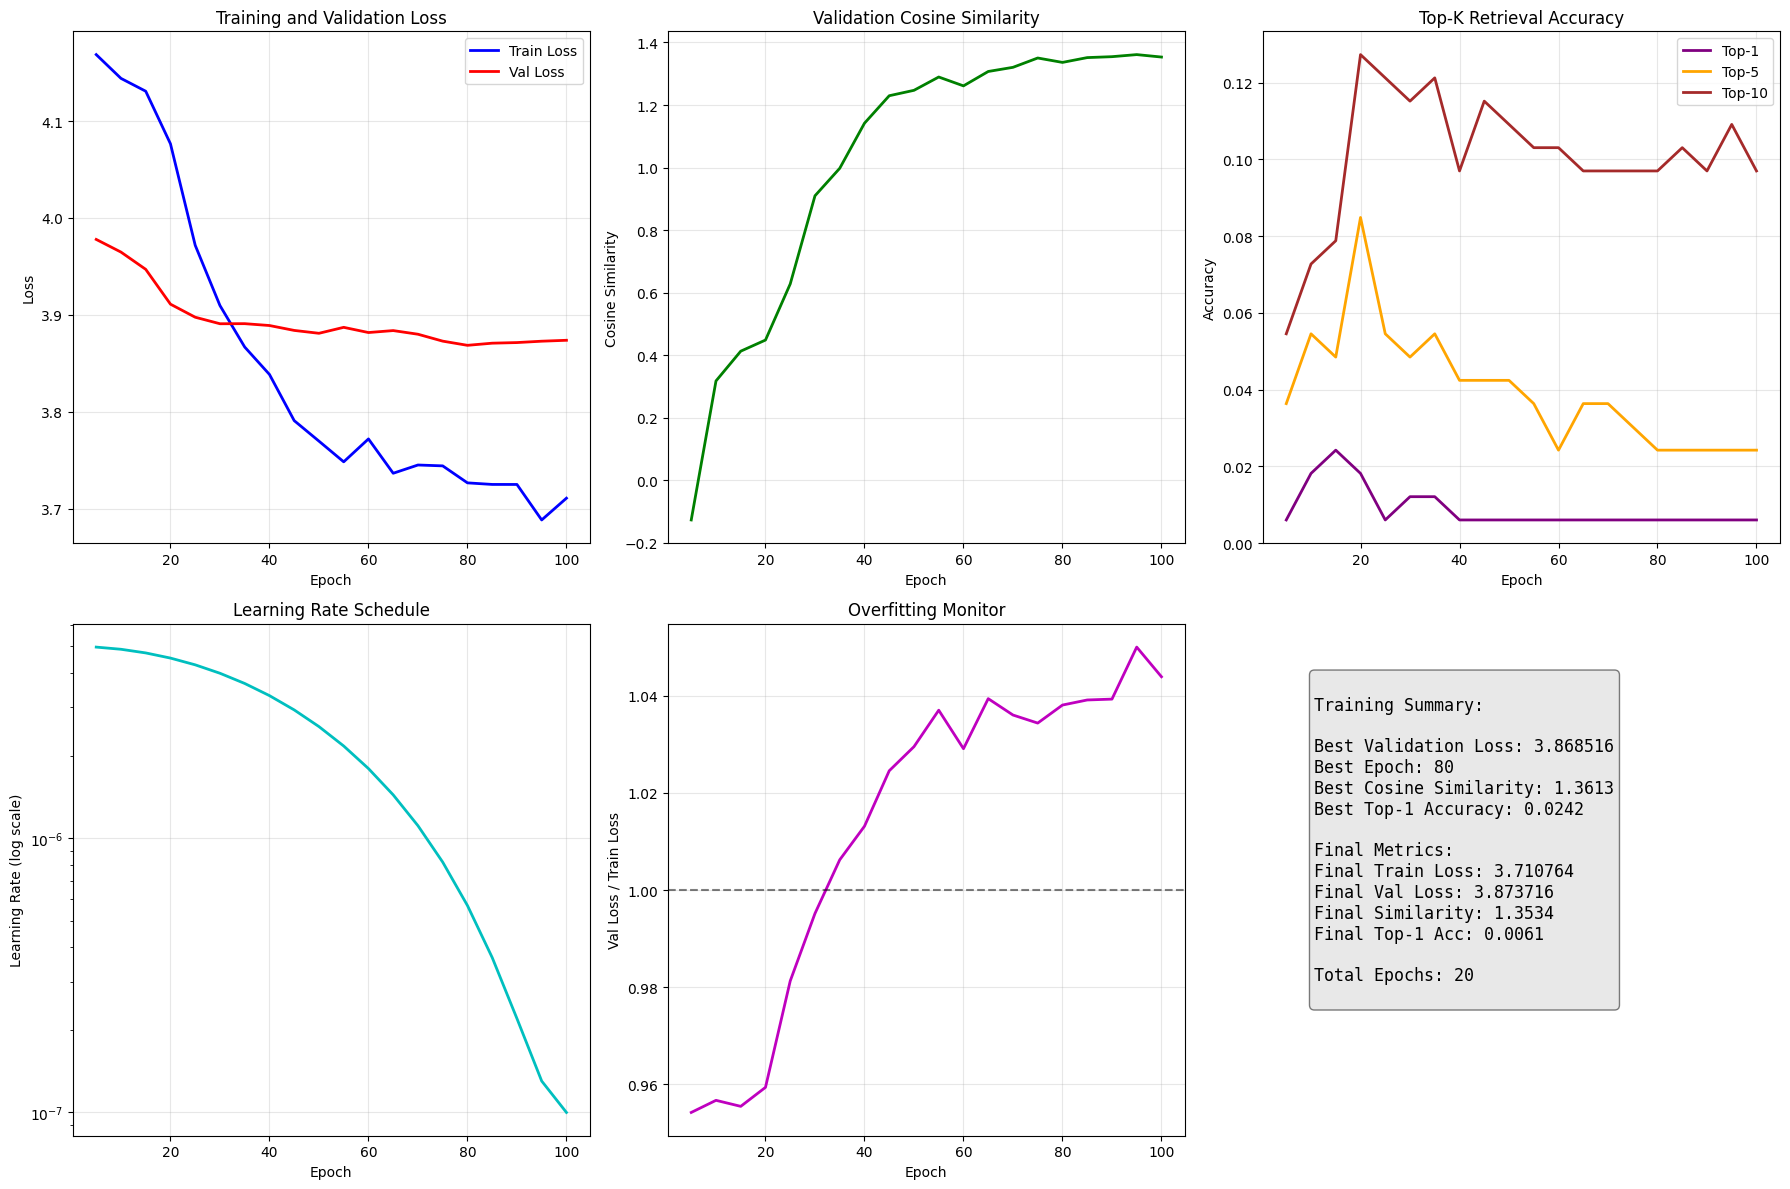

Training plots saved!


In [29]:
# Cell 18: Plot Training Results
def plot_training_results(train_history, output_dir):
    """Plot comprehensive training results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    epochs = train_history['epochs']
    
    # Loss plot
    axes[0, 0].plot(epochs, train_history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, train_history['val_losses'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cosine similarity plot
    axes[0, 1].plot(epochs, train_history['val_similarities'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Cosine Similarity')
    axes[0, 1].set_title('Validation Cosine Similarity')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-K accuracy plot
    axes[0, 2].plot(epochs, train_history['val_top1_acc'], 'purple', label='Top-1', linewidth=2)
    axes[0, 2].plot(epochs, train_history['val_top5_acc'], 'orange', label='Top-5', linewidth=2)
    axes[0, 2].plot(epochs, train_history['val_top10_acc'], 'brown', label='Top-10', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].set_title('Top-K Retrieval Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate plot
    axes[1, 0].semilogy(epochs, train_history['learning_rates'], 'c-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate (log scale)')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss ratio plot
    loss_ratios = [val/train for val, train in zip(train_history['val_losses'], train_history['train_losses'])]
    axes[1, 1].plot(epochs, loss_ratios, 'm-', linewidth=2)
    axes[1, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Val Loss / Train Loss')
    axes[1, 1].set_title('Overfitting Monitor')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary statistics
    axes[1, 2].axis('off')
    
    best_epoch = epochs[np.argmin(train_history['val_losses'])]
    best_val_loss = min(train_history['val_losses'])
    best_similarity = max(train_history['val_similarities'])
    best_top1 = max(train_history['val_top1_acc'])
    
    summary_text = f"""
Training Summary:

Best Validation Loss: {best_val_loss:.6f}
Best Epoch: {best_epoch}
Best Cosine Similarity: {best_similarity:.4f}
Best Top-1 Accuracy: {best_top1:.4f}

Final Metrics:
Final Train Loss: {train_history['train_losses'][-1]:.6f}
Final Val Loss: {train_history['val_losses'][-1]:.6f}
Final Similarity: {train_history['val_similarities'][-1]:.4f}
Final Top-1 Acc: {train_history['val_top1_acc'][-1]:.4f}

Total Epochs: {len(epochs)}
"""
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, 
                    fontsize=12, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training results
if len(train_history['epochs']) > 0:
    plot_training_results(train_history, OUTPUT_DIR)
    print("Training plots saved!")
else:
    print("No training history to plot. Make sure to run at least one evaluation epoch.")